# Customer Behaviour Analysis

# Objective
In this case study, you will be working on E-commerce Customer Behavior Analysis using Apache Spark, a powerful distributed computing framework designed for big data processing. This assignment aims to give you hands-on experience in analyzing large-scale e-commerce datasets using PySpark. You will apply techniques learned in data analytics to clean, transform, and explore customer behavior data, drawing meaningful insights to support business decision-making. Apart from understanding how big data tools can optimize performance on a single machine and across clusters, you will develop a structured approach to analyzing customer segmentation, purchase patterns, and behavioral trends.

# Business Value
E-commerce businesses operate in a highly competitive market where understanding customer behavior is critical to driving growth and retention. To stay ahead, companies must leverage data-driven insights to optimize marketing strategies, personalize customer experiences, and improve product offerings. In this assignment, you will analyze e-commerce transaction data to uncover patterns in purchasing behavior, customer preferences, and sales performance. With Apache Spark's ability to handle large datasets efficiently, businesses can process vast amounts of customer interactions in real-time, helping them make faster and more informed decisions.
As an analyst at an e-commerce company, your task is to examine historical transaction records and customer survey data to derive actionable insights that can drive business growth. Your analysis will help identify high-value customers, segment users based on behavior, and uncover trends in product demand and customer engagement. By leveraging big data analytics, businesses can enhance customer satisfaction, improve retention rates, and maximize revenue opportunities.


# Assignment Tasks
1. Data Preparation
2. Data Cleaning
3. Exploratory Data Analysis
4. Customer Segmentation (RFM Analysis) and Business Insights
5. Evaluation and Conclusion


# Dataset Overview
The dataset can be accessed the following [link](https://drive.google.com/drive/folders/1mBgC5tvZrh1bIBvpXVP_j-au5LFUAwOZ?usp=sharing).

The dataset used in this analysis comprises longitudinal purchase records from 5,027 Amazon.com users in the United States, spanning 2018 to 2022.

It is structured into three CSV files (amazon-purchases.csv, survey.csv, and fields.csv) that capture transactional data, demographic profiles, and survey responses.

Collected with informed consent, the dataset enables analysis of customer behavior, product preferences, and demographic trends.

**NOTE**: Personal identifiers (PII) were removed to ensure privacy, and all data were preprocessed by users before submission.

`Data Dictionary:`

| **Attribute**          | **Description** |
|------------------------|----------------|
| **Order Dates**        | The specific dates when orders were placed, enabling chronological analysis of sales trends. |
| **Title** |The name of the product purchased. |
|**Category** | The classification or group to which the product belongs, facilitating category-wise analysis. |
| **Pricing** | The cost per unit of each product, essential for revenue calculations and pricing strategy assessments. |
| **Quantities** | The number of units of each product ordered in a transaction, aiding in inventory and demand analysis. |
| **Shipping States**    | The states to which products were shipped, useful for geographical sales distribution analysis. |
| **Survey ResponseID**  | A unique identifier linking purchases to customer survey responses, enabling correlation between purchasing behavior and customer feedback. |



# Loading the Datasets

In [1]:
## Installing the libraries if required
# !pip install --quiet pyspark==3.5.4 datasets==3.3.2 pandas==2.2.2 matplotlib==3.10.0 seaborn==0.13.2 numpy==1.26.4 tqdm==4.67.1
!pip install pyspark

In [2]:
# Import necessary libraries
from pyspark.sql import SparkSession

# Initialise Spark session
spark = SparkSession.builder \
    .appName("Customer Behavior Analysis") \
    .getOrCreate()


# Load the paths to the datasets/csv files
amazon_purchases_path = '/content/amazon-purchases.csv'
survey_path = '/content/survey.csv'
fields_path = '/content/fields.csv'

# Load datasets into PySpark DataFrames
amazon_purchases = spark.read.csv(amazon_purchases_path, header=True, inferSchema=True)
survey = spark.read.csv(survey_path, header=True, inferSchema=True)
fields = spark.read.csv(fields_path, header=True, inferSchema=True)

# Merge the datasets
merged_data = amazon_purchases.join(survey, on='Survey ResponseID', how='inner')

# Display the merged data
merged_data.show()

+-----------------+----------+-----------------------+--------+----------------------+--------------------+------------------------+--------------------+-------------+----------------+--------------------+-----------------+-----------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------+--------------------+--------------------+---------------+------------+------------------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|               Title|ASIN/ISBN (Product Code)|            Category|  Q-demos-age|Q-demos-hispanic|        Q-demos-race|Q-demos-education|   Q-demos-income|Q-demos-gender|Q-sexual-orientation|Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-oft|Q-substance-use-cigarettes|Q-substance-use-marijuana|Q-substance-us

#1. Data Preparation

Before analysis, the data needs to be prepared to ensure consistency and efficiency.
- Check for data consistency and ensure all columns are correctly formatted.
- Structure and prepare the dataset for further processing, ensuring that relevant features are retained


In [3]:
from pyspark.sql.functions import sum as spark_sum, col

# Check for missing values in the merged dataset

miss_val = merged_data.select([spark_sum(col(i).isNull().cast("int")).alias(i) for i in merged_data.columns])

miss_val.show()

+-----------------+----------+-----------------------+--------+----------------------+-----+------------------------+--------+-----------+----------------+------------+-----------------+--------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------+----------------+--------------------+---------------+------------+------------------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|Title|ASIN/ISBN (Product Code)|Category|Q-demos-age|Q-demos-hispanic|Q-demos-race|Q-demos-education|Q-demos-income|Q-demos-gender|Q-sexual-orientation|Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-oft|Q-substance-use-cigarettes|Q-substance-use-marijuana|Q-substance-use-alcohol|Q-personal-diabetes|Q-personal-wheelchair|Q-life-changes|Q-sell-YOUR-data|

As we can see that columns like "Shipping Address State","Title","Category","ASIN/ISBN (Product Code)","Q-life-changes" has some missing values. So, lets try to handle it.

In [4]:
# check total number of rows and columns of merged datasets

# Number of rows
rows_num = merged_data.count()

# Number of columns
cols_num = len(merged_data.columns)

print(f"Total Rows: {rows_num}, Total Columns: {cols_num}")


Total Rows: 393001, Total Columns: 30


#2. Data Cleaning <font color = red>[20 marks]</font> <br>

Prepare the data for further analysis by performing data cleaning such as missing value treatment, handle data schema, outlier analysis, and relevant feature engineering techniques.

## 2.1 Handling Missing values <font color = red>[10 marks]</font> <br>
Handle missing values in the data

In [5]:
# Import necessary functions
from pyspark.sql.functions import when, count, col


In [6]:
# Fill missing (null) values with the appropriate techniques as required by the analysis

merged_data = merged_data.fillna({"Shipping Address State": "Unknown Address","Title": "Unknown","Category": "Not Specified",
    "ASIN/ISBN (Product Code)": "Not Available","Q-life-changes": "No Data"})

In [7]:
# Aggregate and count missing values (nulls) for each column after replacement

miss_val = merged_data.select([count(when(col(i).isNull(), i)).alias(i) for i in merged_data.columns])

# Display the count of remaining missing values in each column

miss_val.show()

+-----------------+----------+-----------------------+--------+----------------------+-----+------------------------+--------+-----------+----------------+------------+-----------------+--------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------+----------------+--------------------+---------------+------------+------------------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|Title|ASIN/ISBN (Product Code)|Category|Q-demos-age|Q-demos-hispanic|Q-demos-race|Q-demos-education|Q-demos-income|Q-demos-gender|Q-sexual-orientation|Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-oft|Q-substance-use-cigarettes|Q-substance-use-marijuana|Q-substance-use-alcohol|Q-personal-diabetes|Q-personal-wheelchair|Q-life-changes|Q-sell-YOUR-data|

Now that we have handled the missing values by filling it with appropriate data, there are no missing values left.

## 2.2 Feature Engineering <font color = red>[5 marks]</font> <br>
Perform feature engineering on the dataset to extract relevant/ create new features as required and map specific data types.

In [8]:
from pyspark.sql.functions import col, month, year, to_date

# Perform appropriate feature engineering. Eg. Extract order date, month, year and cast to the appropriate values

# Lets convert the 'Order Date' column to a proper date format, if it's in string format
cust_data = merged_data.withColumn("Order Date", to_date(col("Order Date"), "yyyy-MM-dd"))

# Now extract Year and Month from 'Order Date' column
cust_data = cust_data \
    .withColumn("Order Year", year(col("Order Date"))) \
    .withColumn("Order Month", month(col("Order Date")))

# Display the updated dataset
cust_data.show(10)

+-----------------+----------+-----------------------+--------+----------------------+--------------------+------------------------+--------------------+-------------+----------------+--------------------+-----------------+-----------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------+--------------------+--------------------+---------------+------------+------------------+----------+-----------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|               Title|ASIN/ISBN (Product Code)|            Category|  Q-demos-age|Q-demos-hispanic|        Q-demos-race|Q-demos-education|   Q-demos-income|Q-demos-gender|Q-sexual-orientation|Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-oft|Q-substance-use-cigarettes|Q-substance-use-m

There can be some integer valued columns which can have negative values or invalid attributes.So, lets check it.

In [9]:
# Check for negative values in 'Purchase Price Per Unit' or 'Quantity'
invalid_data = cust_data.filter((col('Purchase Price Per Unit') < 0) | (col('Quantity') < 0))

# Display invalid data
invalid_data.show()


+-----------------+----------+-----------------------+--------+----------------------+-----+------------------------+--------+-----------+----------------+------------+-----------------+--------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------+----------------+--------------------+---------------+------------+------------------+----------+-----------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|Title|ASIN/ISBN (Product Code)|Category|Q-demos-age|Q-demos-hispanic|Q-demos-race|Q-demos-education|Q-demos-income|Q-demos-gender|Q-sexual-orientation|Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-oft|Q-substance-use-cigarettes|Q-substance-use-marijuana|Q-substance-use-alcohol|Q-personal-diabetes|Q-personal-wheelchair|Q-life-ch

As above result, there are no negative values in datasets.

In [10]:
# check the distinct values in the Q-demos-gender column

cust_data.select("Q-demos-gender").distinct().show()

+-----------------+
|   Q-demos-gender|
+-----------------+
|Prefer not to say|
|           Female|
|            Other|
|             Male|
+-----------------+



In [11]:
from pyspark.sql.functions import create_map, lit
from itertools import chain

# Map categorical income to numerical values
income_mapping = {
    'Less than $25,000': 0,
    '$25,000 - $49,999': 1,
    '$50,000 - $74,999': 2,
    '$75,000 - $99,999': 3,
    '$100,000 - $149,999': 4,
    '$150,000 or more': 5
}

# Map gender to numerical values
gender_mapping = {
    'Male': 0,
    'Female': 1,
    'Other': 2,
    'Prefer not to say': 3
}


In [12]:
# Create maps for income and gender
income_map = create_map([lit(i) for i in chain(*income_mapping.items())])
gender_map = create_map([lit(i) for i in chain(*gender_mapping.items())])

# Lets apply the mapping to create new numerical columns
cust_data = cust_data \
    .withColumn("Income_Category", income_map[col("Q-demos-income")]) \
    .withColumn("Gender_Category", gender_map[col("Q-demos-gender")])

# Lets handle if there are any unmapped or missing values like unknown (-1 indicates unknown)
cust_data = cust_data.fillna({'Income_Category': -1, 'Gender_Category': -1})

# Display the updated data
cust_data.select("Q-demos-income", "Income_Category", "Q-demos-gender", "Gender_Category").show(10)

+-----------------+---------------+--------------+---------------+
|   Q-demos-income|Income_Category|Q-demos-gender|Gender_Category|
+-----------------+---------------+--------------+---------------+
|$25,000 - $49,999|              1|          Male|              0|
|$25,000 - $49,999|              1|          Male|              0|
|$25,000 - $49,999|              1|          Male|              0|
|$25,000 - $49,999|              1|          Male|              0|
|$25,000 - $49,999|              1|          Male|              0|
|$25,000 - $49,999|              1|          Male|              0|
|$25,000 - $49,999|              1|          Male|              0|
|$25,000 - $49,999|              1|          Male|              0|
|$25,000 - $49,999|              1|          Male|              0|
|$25,000 - $49,999|              1|          Male|              0|
+-----------------+---------------+--------------+---------------+
only showing top 10 rows



## 2.3 Data Cleaning <font color = red>[5 marks]</font> <br>
Handle data cleaning techniques such as data duplication, dropping unnecessary values etc.

In [13]:
# Check for duplicates
print("Number of Duplicates:", merged_data.count() - merged_data.dropDuplicates().count())

# Remove duplicates
merged_data = merged_data.dropDuplicates()

# Verify duplicates after cleaning
print("Number of Duplicates After Cleaning:", merged_data.count() - merged_data.dropDuplicates().count())

Number of Duplicates: 2330
Number of Duplicates After Cleaning: 0


In [14]:
cleaned_data_path =  "/content/cleaned_data.csv" # Save the cleaned dataset locally
merged_data.write.csv(cleaned_data_path, header=True, mode='overwrite')

# Load the cleaned dataset from the location
cleaned_data = spark.read.csv(cleaned_data_path, header=True, inferSchema=True)

# Display the first few rows
print("Cleaned Data:")
cleaned_data.show(5)

Cleaned Data:
+-----------------+----------+-----------------------+--------+----------------------+--------------------+------------------------+--------------------+-------------+----------------+--------------------+-----------------+-----------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------+--------------------+--------------------+---------------+------------+------------------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|               Title|ASIN/ISBN (Product Code)|            Category|  Q-demos-age|Q-demos-hispanic|        Q-demos-race|Q-demos-education|   Q-demos-income|Q-demos-gender|Q-sexual-orientation|Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-oft|Q-substance-use-cigarettes|Q-substance-use-marijuana|

# 3. Exploratory Data Analysis <font color = red>[55 marks]</font> <br>

## 3.1 Analyse purchases by hour, day and month <font color = red>[5 marks]</font> <br>

Examine overall trends in purchases over time and analyse the trends by hour, day, month.

In [15]:
# Purchase Distribution by Hour, Day, and Month

from pyspark.sql.functions import hour, dayofweek, month, to_timestamp
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Order Date to timestamp if it's not already
merged_data = merged_data.withColumn("Order Date", to_timestamp("Order Date"))

# Extract hour, day of week, and month
from pyspark.sql.functions import hour, dayofweek, month

merged_data = merged_data.withColumn("Hour", hour("Order Date")) \
                           .withColumn("DayOfWeek", dayofweek("Order Date")) \
                           .withColumn("Month", month("Order Date"))

# Group and count purchases by time factors
hr_pur_data = merged_data.groupBy("Hour").count()
day_pur_data = merged_data.groupBy("DayOfWeek").count()
mnth_pur_data = merged_data.groupBy("Month").count()

# Convert to Pandas for visualisation
hour_df = hr_pur_data.toPandas()
day_df = day_pur_data.toPandas()
month_df = mnth_pur_data.toPandas()


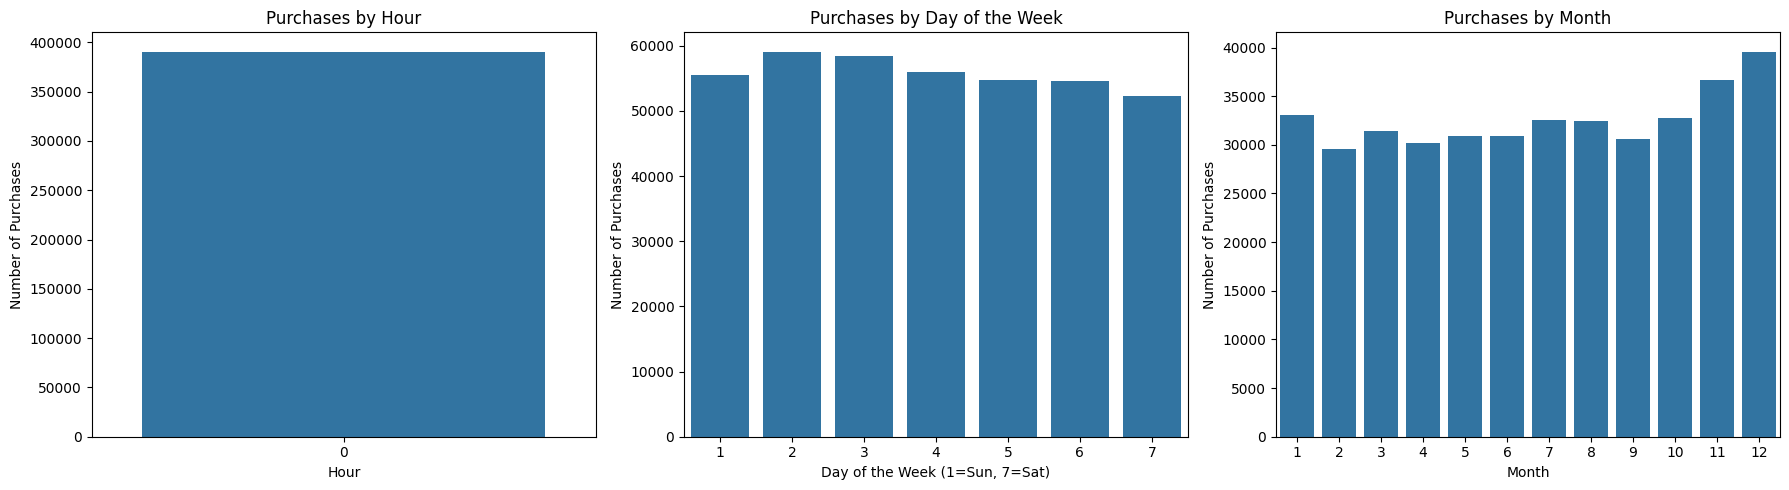

In [16]:
# Plot the data
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Hourly Data
sns.barplot(x="Hour", y="count", data=hour_df, ax=axes[0])
axes[0].set_title("Purchases by Hour")
axes[0].set_xlabel("Hour")
axes[0].set_ylabel("Number of Purchases")

# Plot Daily Data
sns.barplot(x="DayOfWeek", y="count", data=day_df, ax=axes[1])
axes[1].set_title("Purchases by Day of the Week")
axes[1].set_xlabel("Day of the Week (1=Sun, 7=Sat)")
axes[1].set_ylabel("Number of Purchases")

# Plot Monthly Data
sns.barplot(x="Month", y="count", data=month_df, ax=axes[2])
axes[2].set_title("Purchases by Month")
axes[2].set_xlabel("Month")
axes[2].set_ylabel("Number of Purchases")

plt.tight_layout()
plt.show()


As shown by above graph, the highest purchases were mostly done on weekday i.e. 'Monday' and in month of 'December'.

In [17]:
# Monthly-Year Purchase Trends

from pyspark.sql.functions import date_format

# Extract month and year from 'Order Date'in "YYYY-MM" format
merged_data = merged_data.withColumn("YearMonth", date_format("Order Date", "yyyy-MM"))

# Group by month and count purchases
yr_mnth_data = merged_data.groupBy("YearMonth").count().orderBy("YearMonth")

# Convert to Pandas for visualisation
yr_mnth_df = yr_mnth_data.toPandas()


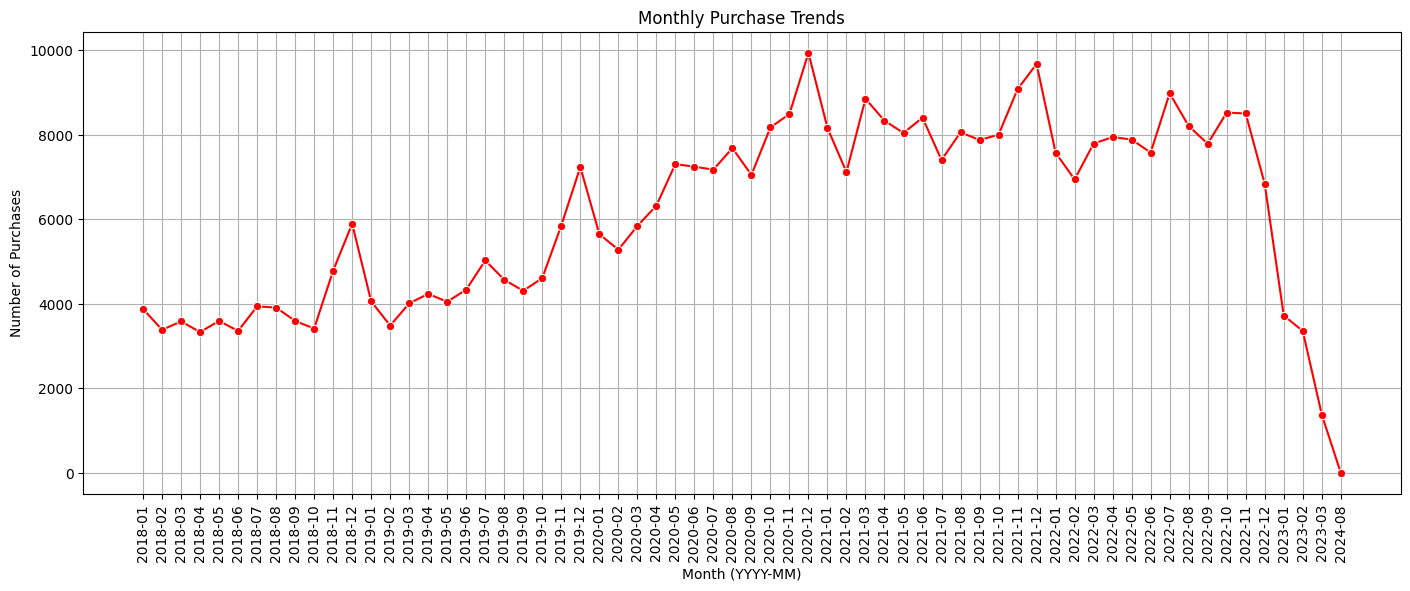

In [18]:
# Plot Monthly-Year Purchase Trends

plt.figure(figsize=(17, 6))

sns.lineplot(x="YearMonth", y="count", data=yr_mnth_df, marker='o', color='red')
plt.xticks(rotation=90)
plt.title("Monthly Purchase Trends")
plt.xlabel("Month (YYYY-MM)")
plt.ylabel("Number of Purchases")
plt.grid(True)
plt.show()

From above data, in year-month i.e. December-2020, the purchase trend was shown high. And the second time it was high in December-2021.

In [19]:
# Yearly Purchase Trends

from pyspark.sql.functions import date_format

# Extract the year from the 'Order Date' column and group by Year and count purchases
year_data = merged_data.withColumn("Year", year("Order Date")).groupBy("Year").count().orderBy("Year")

# Convert to Pandas for visualisation
year_df = year_data.toPandas()


<ipython-input-20-6a53fc1d31ac>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Year", y="count", data=year_df, palette="viridis")


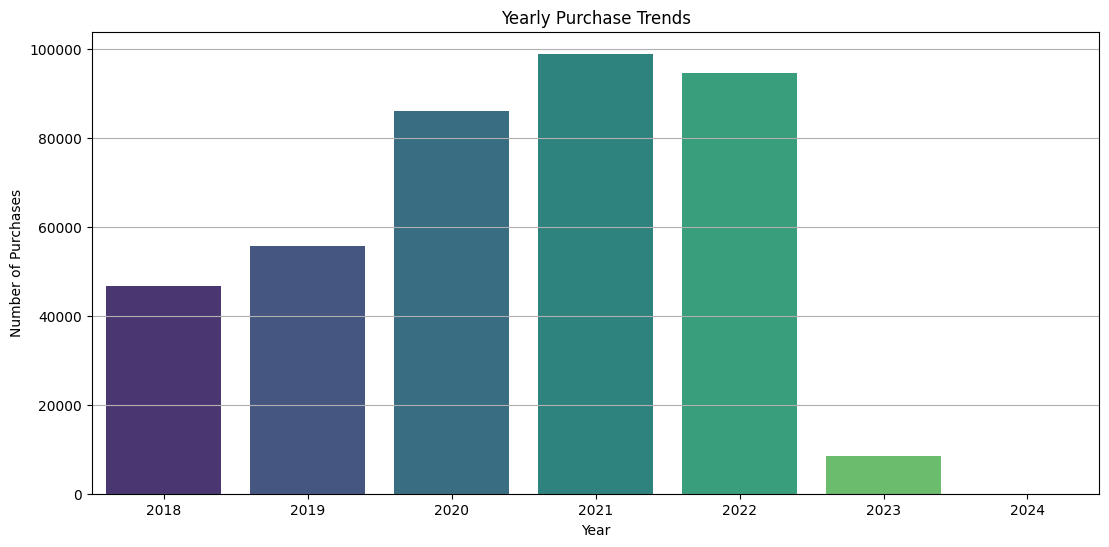

In [20]:
# Plot Yearly Purchase Trends

plt.figure(figsize=(13, 6))
sns.barplot(x="Year", y="count", data=year_df, palette="viridis")
plt.title("Yearly Purchase Trends")
plt.xlabel("Year")
plt.ylabel("Number of Purchases")
plt.grid(axis='y')
plt.show()

Overall purchases made by customer was mostly in year of 2021.

## 3.2 Customer Demographics vs Purchase Frequency <font color = red>[5 marks]</font> <br>
Analyse the trends between the customer deographics and the purchase frequency

In [21]:
# Correlation Between Demographics and Purchase Frequency

from pyspark.sql.functions import count

# Group by demographic attributes and count purchases
demo_grph_data = merged_data.groupBy("Q-demos-age","Q-demos-gender","Q-demos-income","Q-demos-hispanic","Q-demos-race","Q-demos-education","Q-demos-state") \
                            .agg(count("Survey ResponseID").alias("Purchase Count")) \
                            .orderBy("Q-demos-age", "Q-demos-gender", "Q-demos-income","Q-demos-hispanic","Q-demos-race","Q-demos-education","Q-demos-state")

# Convert to Pandas for visualization
demographic_df = demo_grph_data.toPandas()


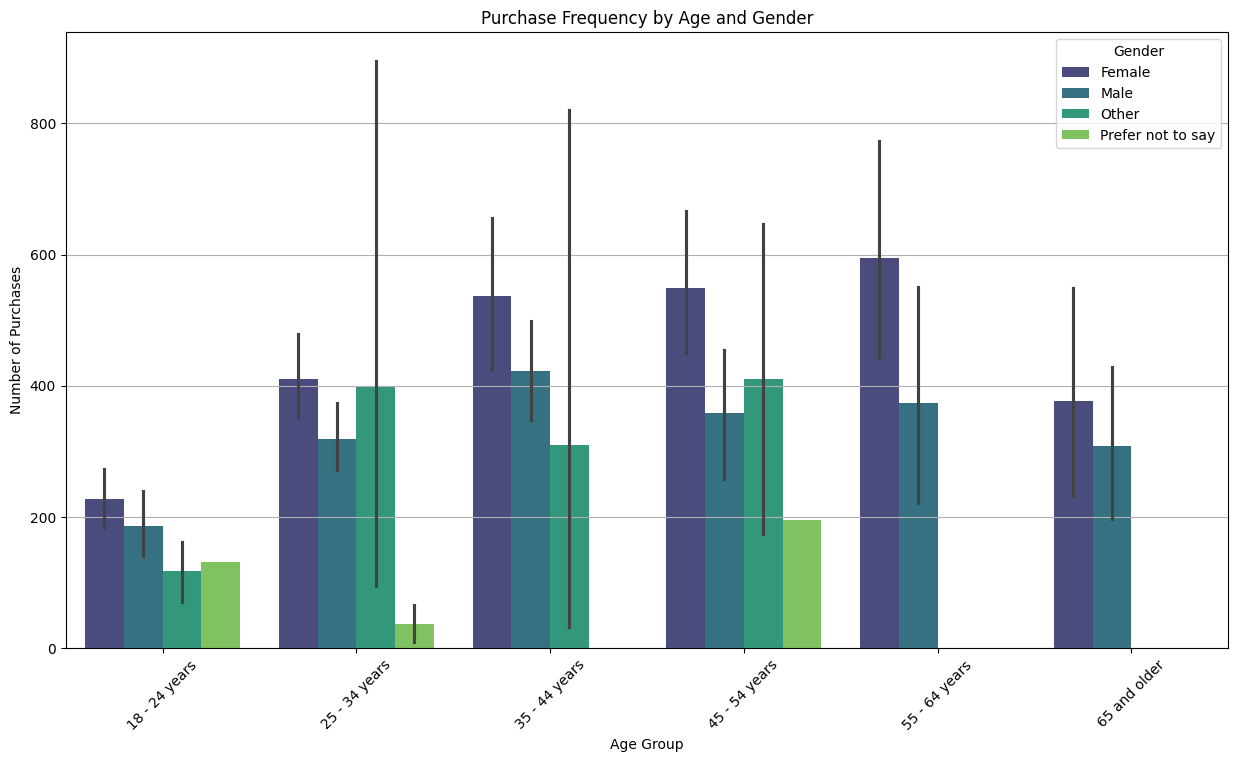

In [22]:
# Plot the Purchase Frequency by Age, Gender, and Income

plt.figure(figsize=(15, 8))

sns.barplot(x='Q-demos-age', y='Purchase Count', hue='Q-demos-gender', data=demographic_df, palette='viridis')

plt.title("Purchase Frequency by Age and Gender")
plt.xlabel("Age Group")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.grid(axis='y')
plt.show()


From above graph, its clear that in Gender category **Females** of age **55-64 years** exhibits high purchase sales as compared to other category values.

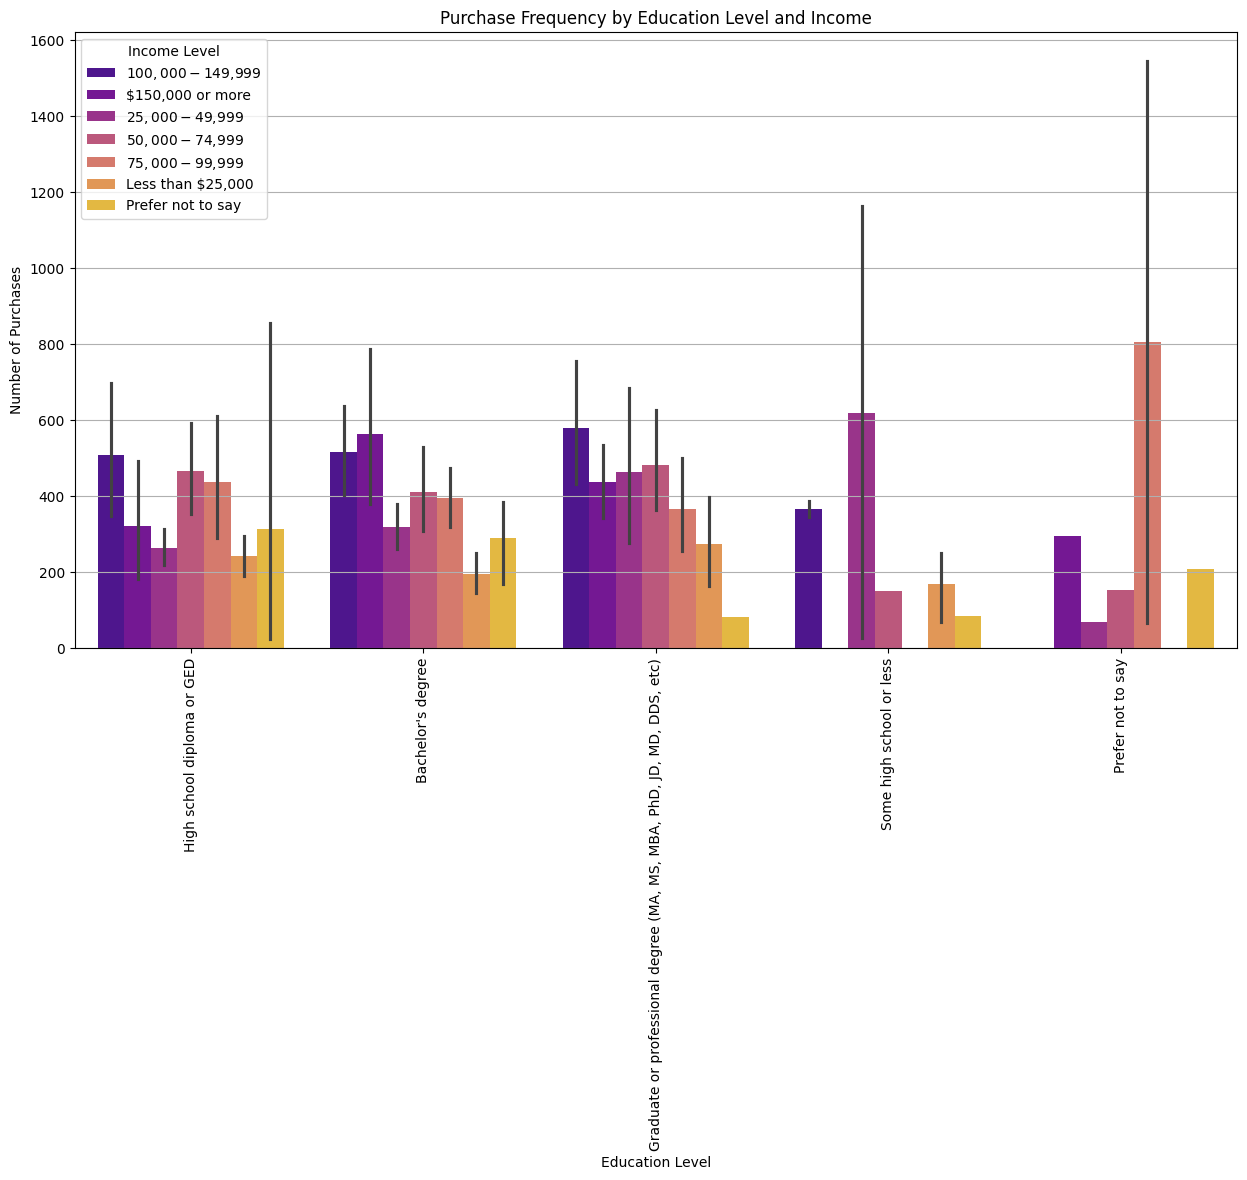

In [23]:
# Plot the Purchase Frequency by Education Level and Income

plt.figure(figsize=(15, 8))

sns.barplot(x='Q-demos-education', y='Purchase Count', hue='Q-demos-income', data=demographic_df, palette='plasma')

plt.title("Purchase Frequency by Education Level and Income")
plt.xlabel("Education Level")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=90)
plt.legend(title='Income Level')
plt.grid(axis='y')
plt.show()


The customers who prefers not to show their education level with income Level of $50,000-74,999 makes highest number of Purchases.

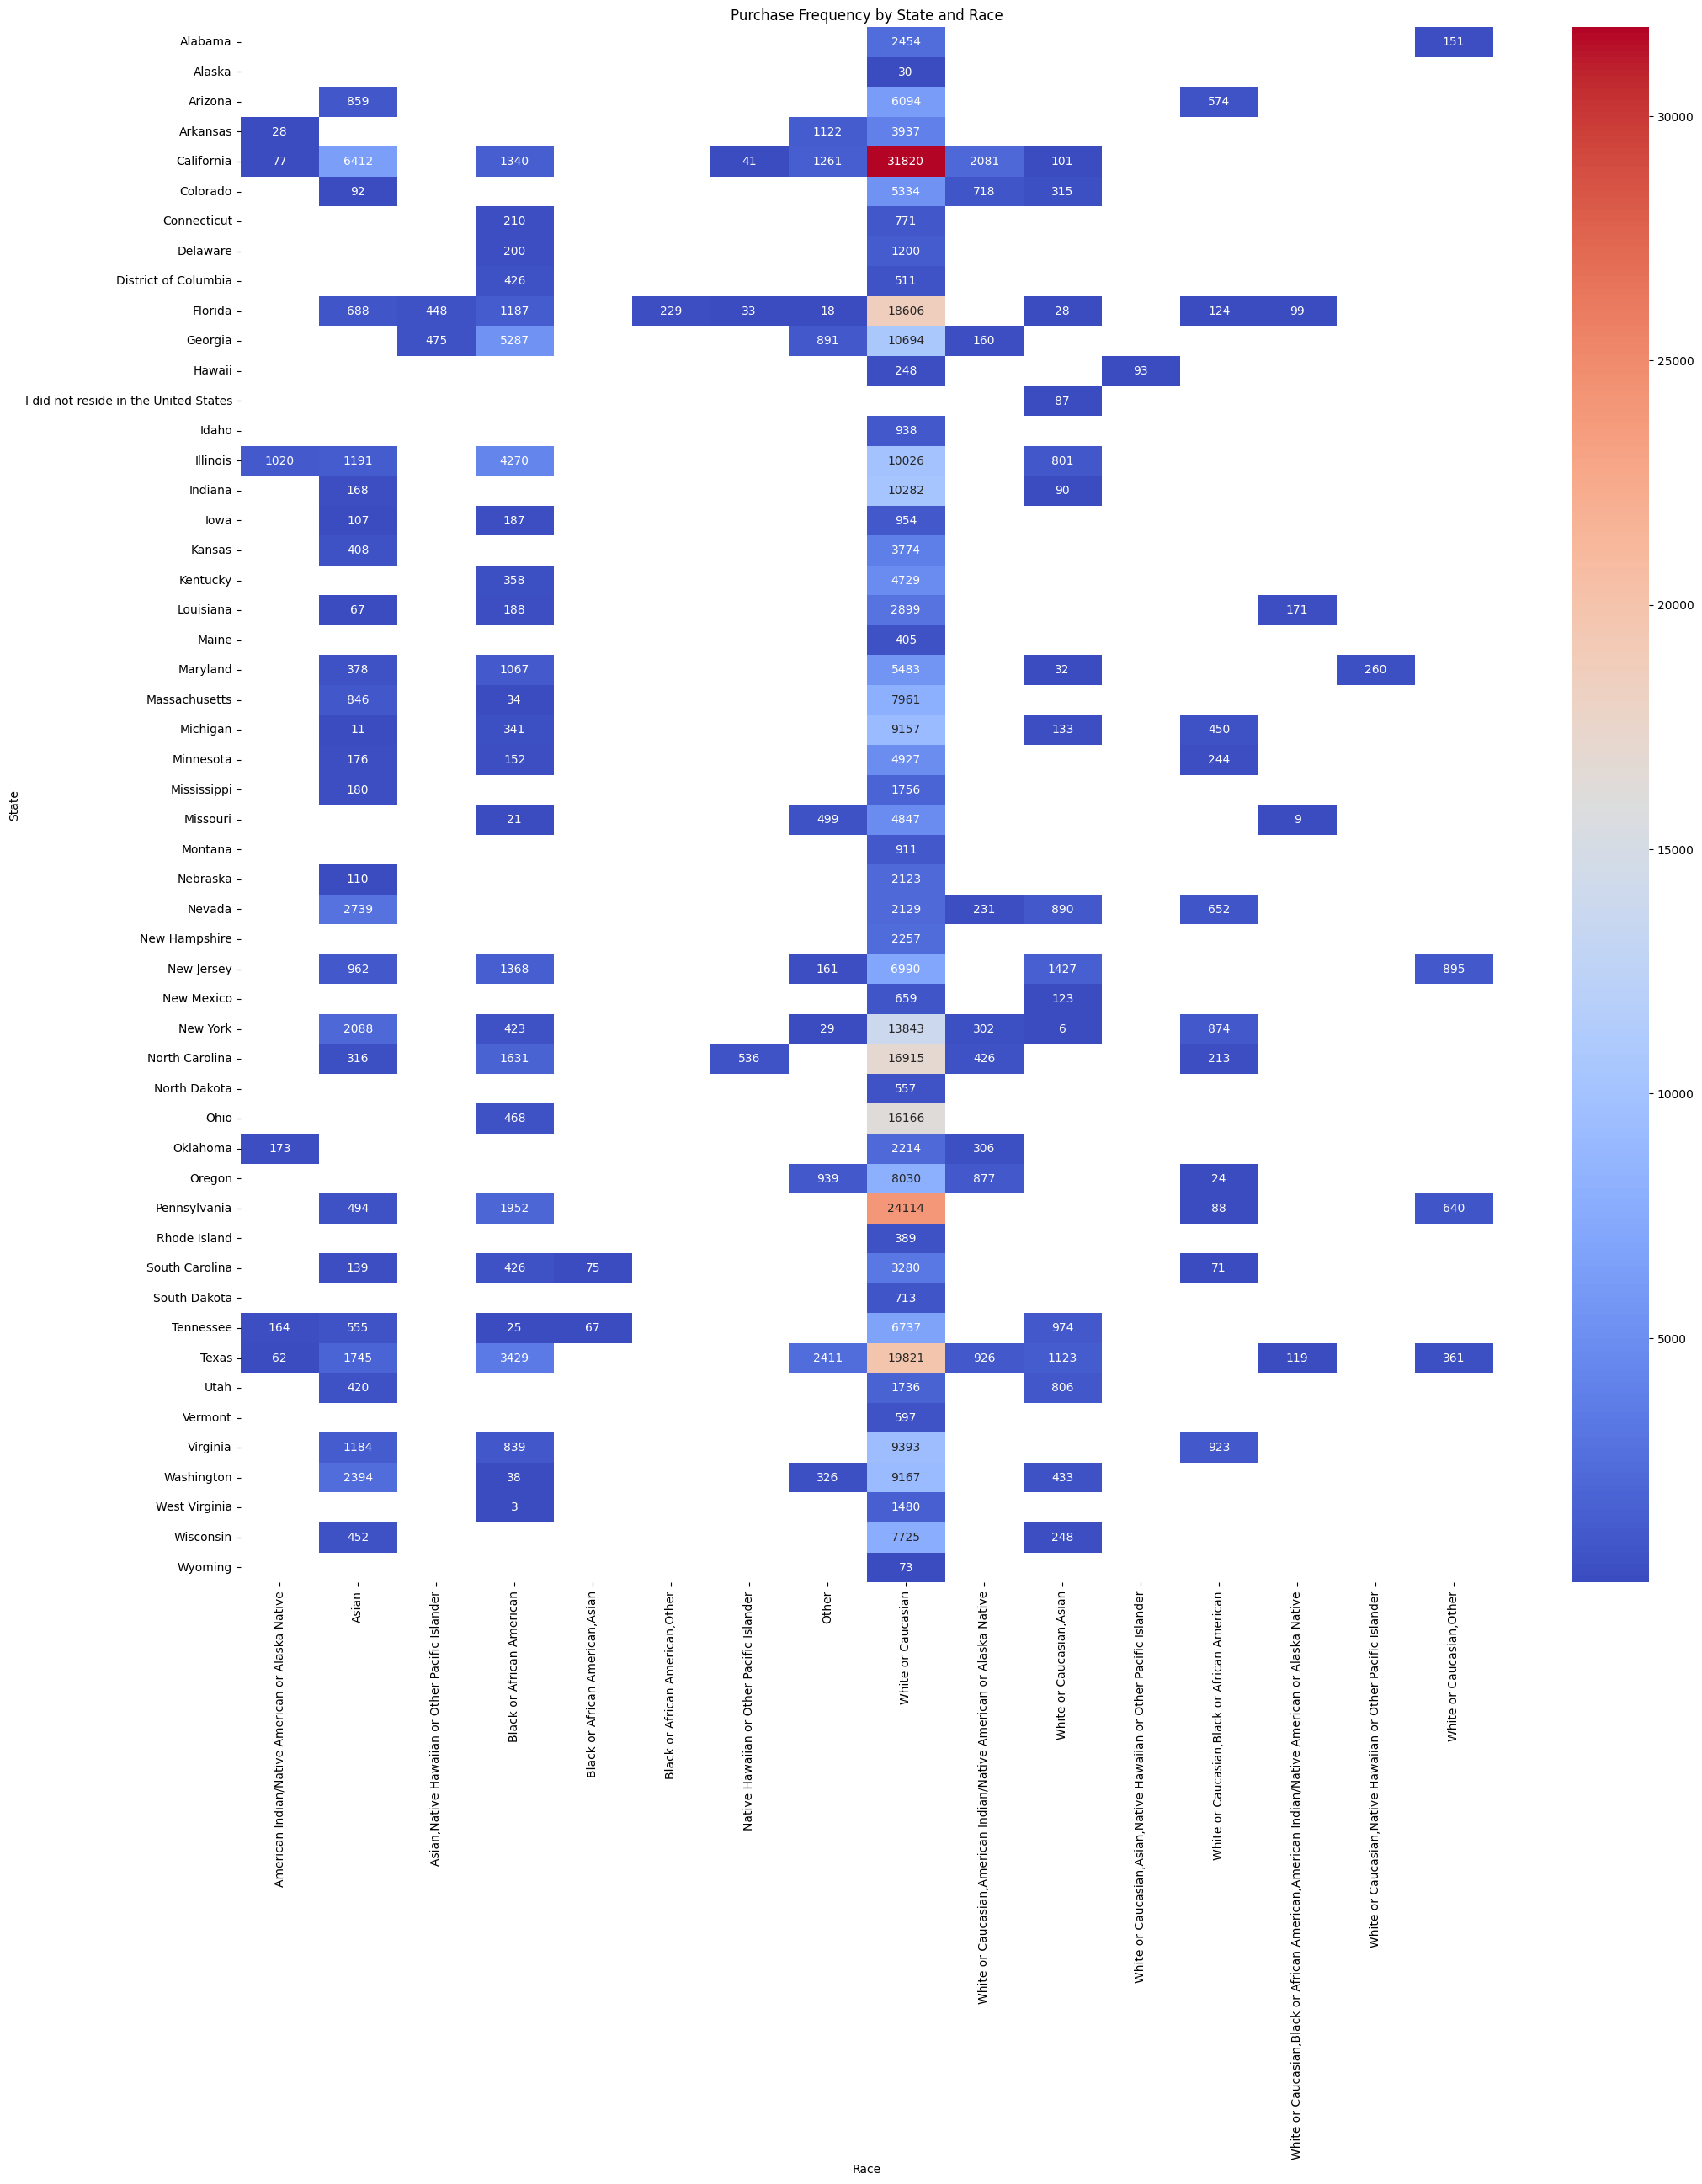

In [24]:
# Plot the Heatmap of Purchases by State and Race

aggr_df = demographic_df.groupby(["Q-demos-state", "Q-demos-race"]) \
                               .agg({"Purchase Count": "sum"}) \
                               .reset_index()

pvt = aggr_df.pivot(index="Q-demos-state", columns="Q-demos-race", values="Purchase Count")

plt.figure(figsize=(24, 24))
sns.heatmap(pvt, cmap="coolwarm", annot=True, fmt=".0f")
plt.title("Purchase Frequency by State and Race")
plt.xlabel("Race")
plt.ylabel("State")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


Above heatmap shows that ,in the state of "California", the race of White or Caucasian has highest purchases.

## 3.3 Purchase behavior weekend vs weekday <font color = red>[5 marks]</font> <br>

Compare the purchase behavior of customer's on weekdays vs. weekends.

In [25]:
# Weekday vs. Weekend Purchase Behavior

from pyspark.sql.functions import when

# Define weekdays and weekends where 1 = Sunday, 7 = Saturday (weekends) and 2 to 6 (Monday to Friday) are weekdays.
# Add a new column distributed transactions as "Weekday" or "Weekend"

merged_data = merged_data.withColumn("Day_Type",when(dayofweek("Order Date").isin(1, 7), "Weekend").otherwise("Weekday"))

# Group and count purchases
pur_behv = merged_data.groupBy("Day_Type").agg(count("*").alias("Purchase Count"))

# Convert to Pandas for visualization
pur_behv_df = pur_behv.toPandas()


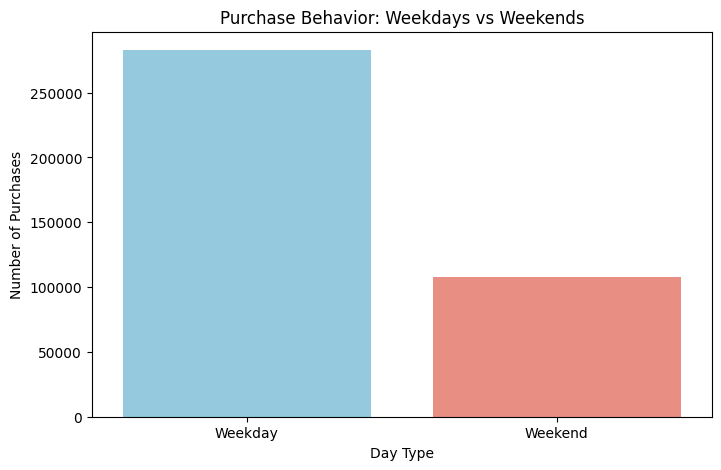

In [26]:
# Plot Purchase behaviour for Weekdays vs Weekends

plt.figure(figsize=(8, 5))

sns.barplot(data=pur_behv_df, x="Day_Type", y="Purchase Count", hue="Day_Type", palette={"Weekday": "skyblue", "Weekend": "salmon"}, legend=False)

plt.title("Purchase Behavior: Weekdays vs Weekends")
plt.xlabel("Day Type")
plt.ylabel("Number of Purchases")
plt.show()

As shown in above graph, Weekday exhibit higher sales compared to Weekend.

## 3.4 Frequently purchased product pairs <font color = red>[5 marks]</font> <br>

Analyze how frequently products are purchased together (also known as Market Basket Analysis)


In [27]:
# Frequently Purchased Product Pairs (Market Basket Analysis)

from pyspark.sql.functions import collect_set, explode

# Group by Survey ResponseID and collect products purchased together
pdt_pairs_df = merged_data.groupBy("Survey ResponseID").agg(collect_set("Title").alias("Products"))
pdt_pairs_df.show(10)


+-----------------+--------------------+
|Survey ResponseID|            Products|
+-----------------+--------------------+
|R_038ZU6kfQ5f89fH|[Rehab Ink Comple...|
|R_06RZP9pS7kONINr|[Cinderella (Two-...|
|R_085qq7w0pkhowox|[FaroDor Women's ...|
|R_0Arj0ePpTnReV1v|[(2-Pack) A5 Dot ...|
|R_0BWkZUjRId7FDZn|[Onix Fuse Indoor...|
|R_0D6GtQwa6VcnXpv|[Bellemain Stainl...|
|R_0D6LkYgiPcEN117|[Toysmith Euler's...|
|R_0Hzrb8hEmXavTk5|[Smart Sweets SMA...|
|R_0IilpPYiU01nCzn|[Mont Marte Art P...|
|R_0TXaBMuEhEzmPVD|[2 Pack - Aluminu...|
+-----------------+--------------------+
only showing top 10 rows



In [28]:
# Explode item pairs

pdt_pairs_df = pdt_pairs_df.withColumn("Product", explode(col("Products")))
pdt_pairs_df = pdt_pairs_df.alias("df1").join(pdt_pairs_df.alias("df2"), col("df1.Product") != col("df2.Product")) \
    .select(col("df1.Product").alias("Product A"), col("df2.Product").alias("Product B"))

pdt_pairs_df.show(10)

+--------------------+--------------------+
|           Product A|           Product B|
+--------------------+--------------------+
|Crest Scope Outla...|Poetic SlimFolio ...|
|Crest Scope Outla...|Sleep Earphone fo...|
|Crest Scope Outla...|Syncwire USB C to...|
|Crest Scope Outla...|365 by Whole Food...|
|Crest Scope Outla...|JUST BARE Natural...|
|Crest Scope Outla...|OTTERBOX COMMUTER...|
|Crest Scope Outla...|Furmax Office Cha...|
|Crest Scope Outla...|Seagate One Touch...|
|Crest Scope Outla...|Valuetoner Ink Ca...|
|Crest Scope Outla...|Dietz & Watson Sl...|
+--------------------+--------------------+
only showing top 10 rows



In [29]:
# Calculate Total Revenue and Item Popularity

count_pairs = pdt_pairs_df.groupBy("Product A", "Product B") \
    .agg(count("*").alias("Count")) \
    .orderBy(col("Count").desc())\
    .limit(100)


In [30]:
# Convert to Pandas for visualisation

count_pairs = count_pairs.repartition(200)  # Adjust number as needed


In [31]:
count_pairs = count_pairs.persist()


In [32]:
count_pairs = count_pairs.select("Product A", "Product B", "Count").limit(1000)


## 3.5 Examine Product Performance <font color = red>[5 marks]</font> <br>

Examine the performance of products by calculating revenue and item popularity.

Item Popularity: products purchased counts

Total Revenue: Quantity * Purchase Price Per Unit

In [33]:
# Contribution of Product Categories (Top 25)

pdt_per = merged_data.groupBy("Category", "Title").agg(spark_sum(col("Purchase Price Per Unit") * col("Quantity")) \
                        .alias("Total Revenue"), count("*").alias("Item Popularity") ).orderBy(col("Total Revenue").desc())

pdt_per.show(25)

+--------------------+--------------------+------------------+---------------+
|            Category|               Title|     Total Revenue|Item Popularity|
+--------------------+--------------------+------------------+---------------+
|       Not Specified|             Unknown| 491926.5599999785|          19151|
|           GIFT_CARD|Amazon.com Gift C...|48310.640000000014|           1747|
|           GIFT_CARD|Amazon.com eGift ...|          28865.65|            667|
|      ABIS_GIFT_CARD|       Amazon Reload|21708.700000000004|            917|
|ELECTRONIC_GIFT_CARD|Amazon.com eGift ...| 9010.710000000001|            174|
|           GIFT_CARD|Apple Gift Card -...|            9007.9|            181|
|           GIFT_CARD|$200 Visa Gift Ca...| 7657.149999999998|             34|
|          HEADPHONES|Apple AirPods (2n...| 7188.549999999997|             50|
|           GIFT_CARD|Uber Gift Card - ...|           6155.05|            193|
|           GIFT_CARD|DoorDash Gift Car...|         

In [34]:
# Convert to Pandas for visualisation

pdt_per_df = pdt_per.toPandas()

# Select Top 25 Categories

top_25 = pdt_per_df.head(25)

<ipython-input-35-90ce2d90f473>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25, x="Total Revenue", y="Category", palette="viridis")


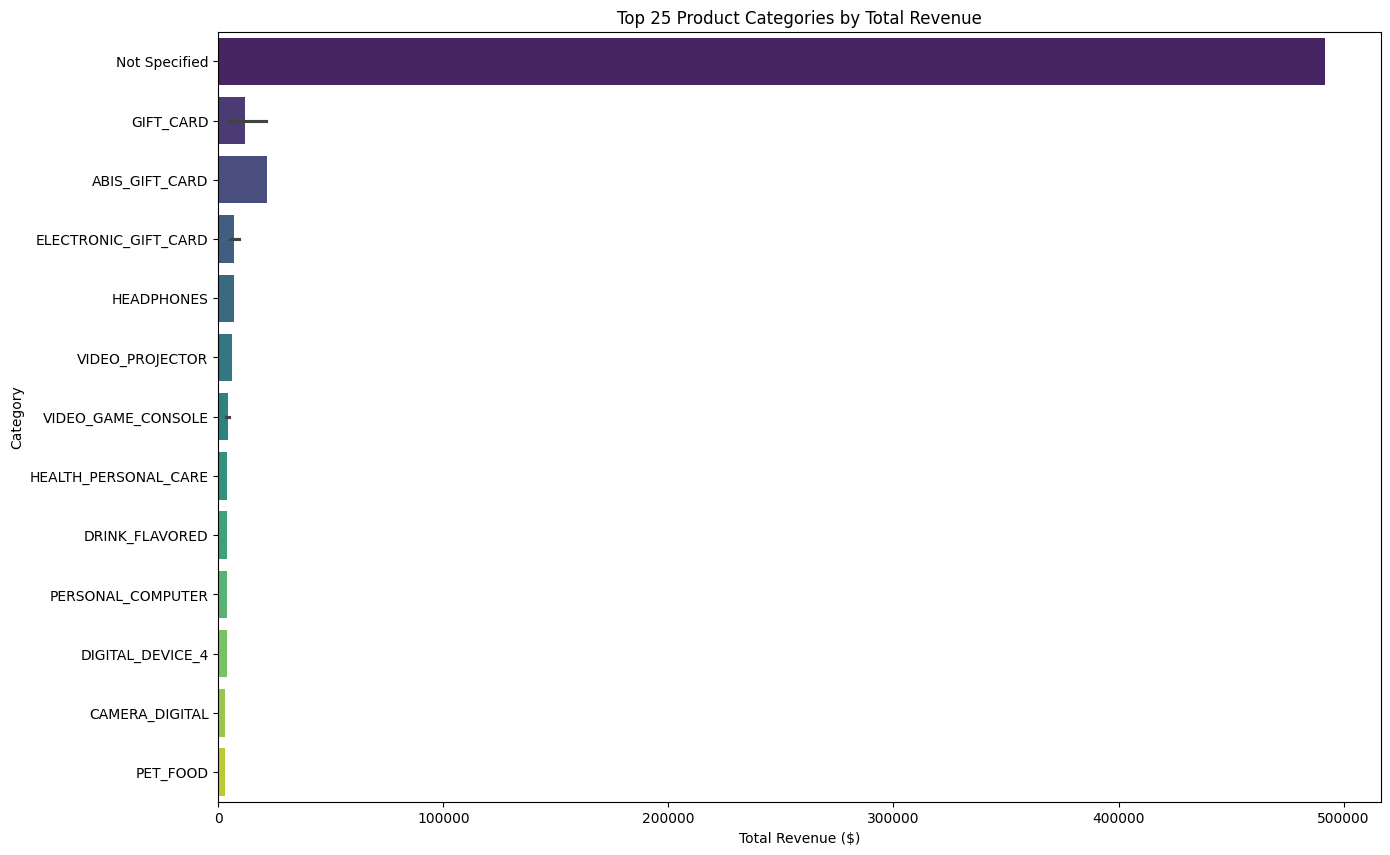

<ipython-input-35-90ce2d90f473>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25, x="Item Popularity", y="Category", palette="plasma")


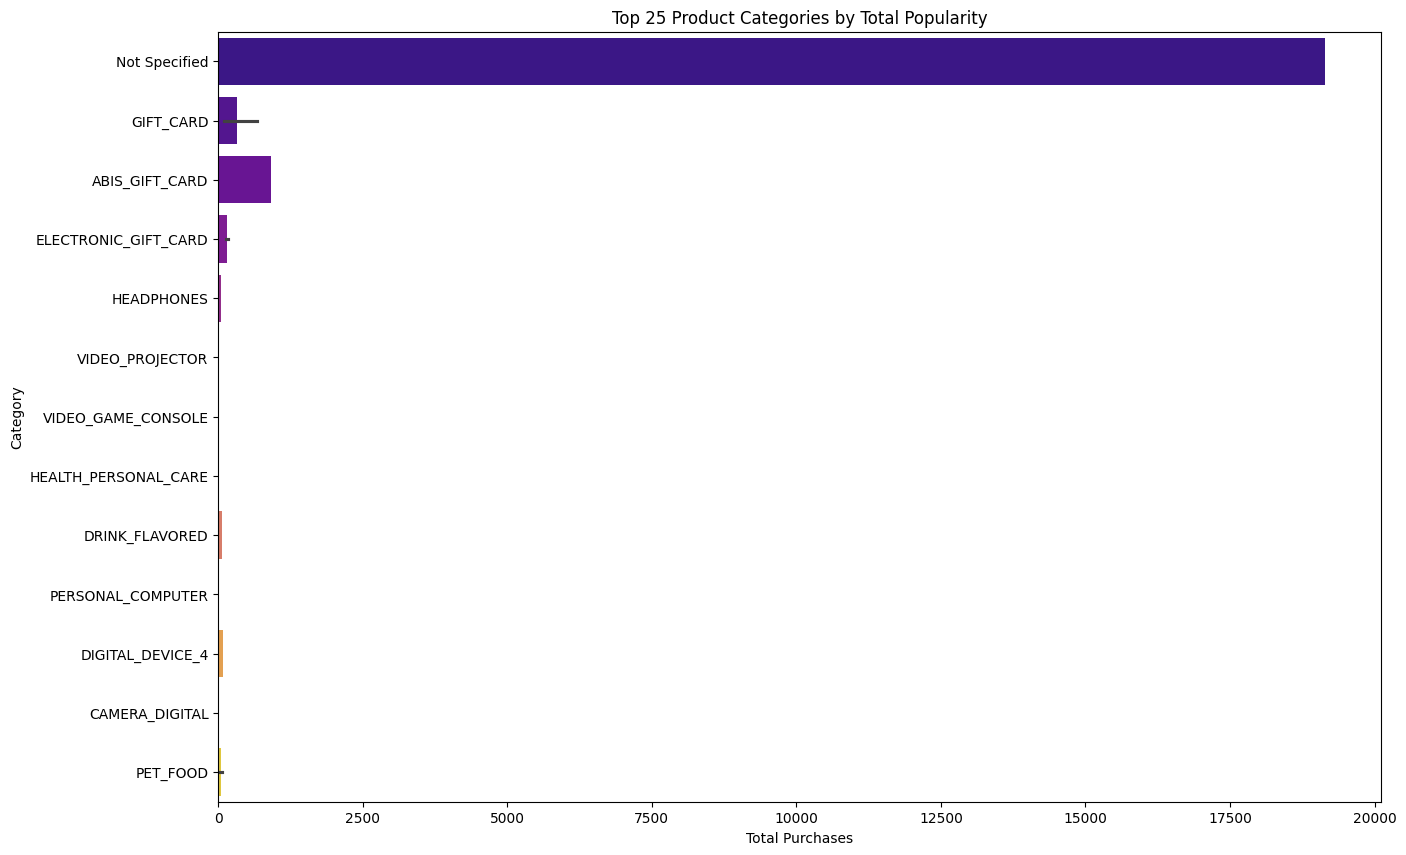

In [35]:
# Plot Total Revenue by Category
plt.figure(figsize=(15, 10))
sns.barplot(data=top_25, x="Total Revenue", y="Category", palette="viridis")
plt.title("Top 25 Product Categories by Total Revenue")
plt.xlabel("Total Revenue ($)")
plt.ylabel("Category")
plt.show()

# Plot Total Popularity by Category
plt.figure(figsize=(15, 10))
sns.barplot(data=top_25, x="Item Popularity", y="Category", palette="plasma")
plt.title("Top 25 Product Categories by Total Popularity")
plt.xlabel("Total Purchases")
plt.ylabel("Category")
plt.show()

Products like ABIS Book, Gift Card, Electronic Gift cards, Headphones and many more were high in both Popularity and Total Revenue.Items as “Not Specified” spike the revenue and were top popular items


## 3.6 Top products by quantity <font color = red>[5 marks]</font> <br>

Identify the most frequently purchased products.

In [36]:
# Group by product title and sum 'Quantity' and show Top 10 Products by Quantity

top_pdt_quantity = merged_data.groupBy("Title") \
    .agg(spark_sum("Quantity").alias("Total Quantity")) \
    .orderBy(col("Total Quantity").desc()) \
    .limit(10)

top_pdt_quantity.show()

# Convert to Pandas for visualisation

top_pdt_df = top_pdt_quantity.toPandas()

+--------------------+--------------+
|               Title|Total Quantity|
+--------------------+--------------+
|             Unknown|       20543.0|
|Amazon.com Gift C...|        1747.0|
|       Amazon Reload|        1031.0|
|Amazon.com eGift ...|         890.0|
|Photo Prints – Gl...|         302.0|
|Photo Prints – Gl...|         232.0|
|Google Play gift ...|         214.0|
|Apple Gift Card -...|         211.0|
|Uber Gift Card - ...|         207.0|
|    Cucumber Slicing|         198.0|
+--------------------+--------------+



<ipython-input-37-7d0678b406a1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total Quantity', y='Title', data=top_pdt_df, palette='plasma')


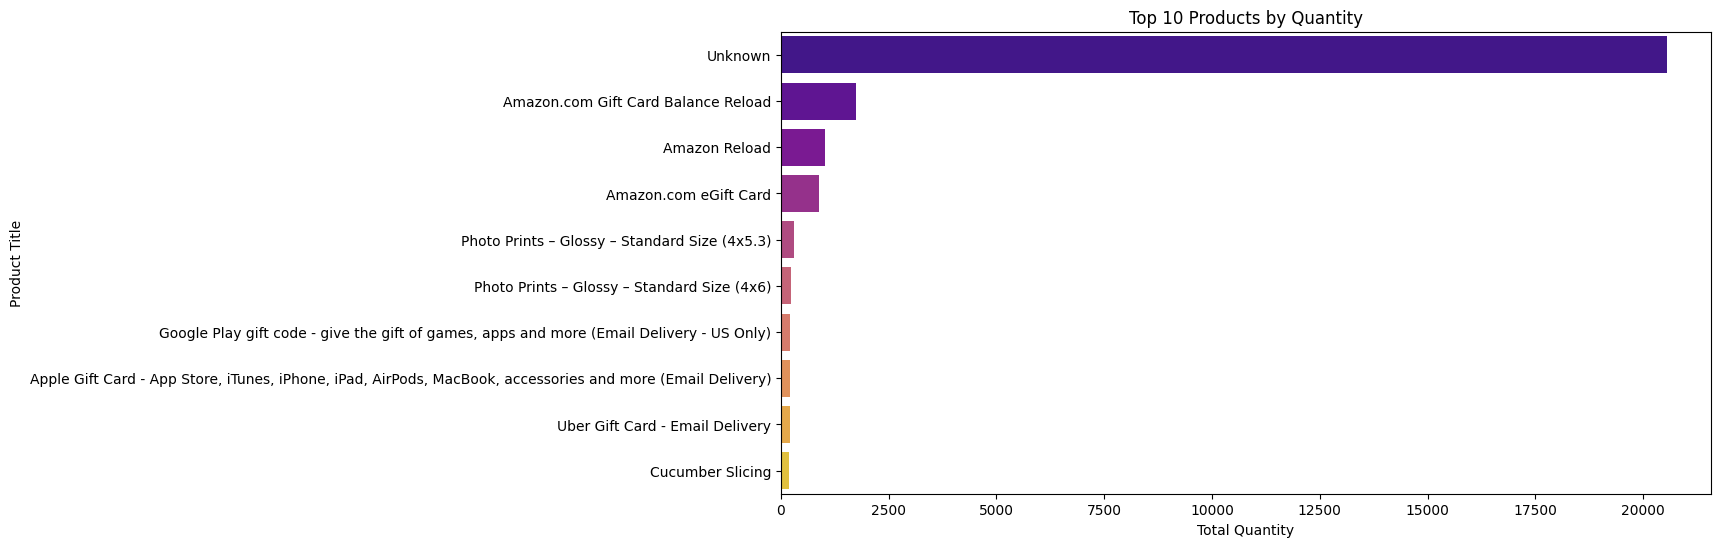

In [37]:
# Plot most frequently purchased products

plt.figure(figsize=(12, 6))

sns.barplot(x='Total Quantity', y='Title', data=top_pdt_df, palette='plasma')

plt.title('Top 10 Products by Quantity')
plt.xlabel('Total Quantity')
plt.ylabel('Product Title')
plt.show()

Topmost frequently purchased Products by customer were most named “Unknown” but some of were  Amazon.com eGift  Cards, Amazon.com Gift  Card Balance Reload, Amazon Reload, Photo Prints and many more.

## 3.7 Distribution of Purchases by State <font color = red>[5 marks]</font> <br>

Analyze the distribution of purchases across states and categories.

In [38]:
# Distribution of Purchases by State (Top 25)

state_data = merged_data.groupBy("Shipping Address State") \
    .agg(spark_sum("Quantity").alias("Total_Purchases")) \
    .orderBy(col("Total_Purchases").desc()) \
    .limit(25)

state_data.show()

+----------------------+---------------+
|Shipping Address State|Total_Purchases|
+----------------------+---------------+
|                    CA|        43270.0|
|                    TX|        33778.0|
|                    PA|        25118.0|
|                    FL|        22916.0|
|       Unknown Address|        21739.0|
|                    NC|        20207.0|
|                    NY|        18463.0|
|                    OH|        18196.0|
|                    IL|        17763.0|
|                    GA|        14764.0|
|                    VA|        13289.0|
|                    NJ|        12888.0|
|                    WA|        12227.0|
|                    MI|        10327.0|
|                    OR|        10260.0|
|                    IN|         9524.0|
|                    MA|         9130.0|
|                    TN|         8696.0|
|                    AZ|         8225.0|
|                    CO|         8015.0|
+----------------------+---------------+
only showing top

In [39]:
# Convert to Pandas for visualisation

state_distribution_df = state_data.toPandas()

<ipython-input-40-503e3dfa354f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Purchases', y='Shipping Address State', data=state_distribution_df, palette='viridis')


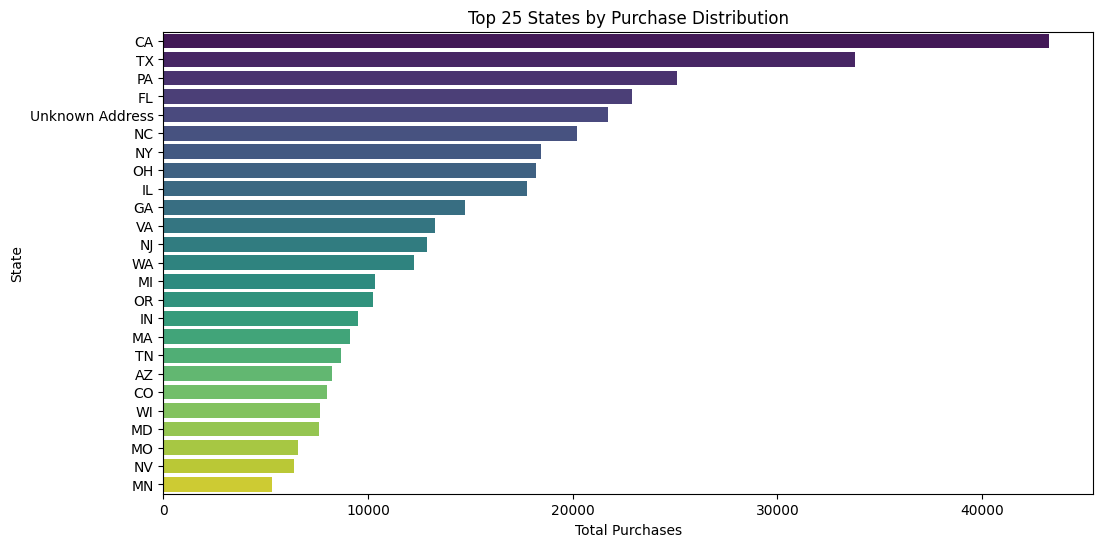

In [40]:
# Plot distribution of purchase by state

plt.figure(figsize=(12, 6))

sns.barplot(x='Total_Purchases', y='Shipping Address State', data=state_distribution_df, palette='viridis')

plt.title('Top 25 States by Purchase Distribution')
plt.xlabel('Total Purchases')
plt.ylabel('State')
plt.show()

Topmost State by Purchase Distribution was CA (California) followed by TX (Texas), FL (Florida) and many more.

## 3.8 Price vs Product Quantity <font color = red>[5 marks]</font> <br>

Identify the Relationship between Price and Quantity

In [41]:
# Relationship Between Price and Quantity

price_quant_data = merged_data.select("Purchase Price Per Unit", "Quantity")

# Convert to Pandas for visualisation

price_quant_pd = price_quant_data.toPandas()

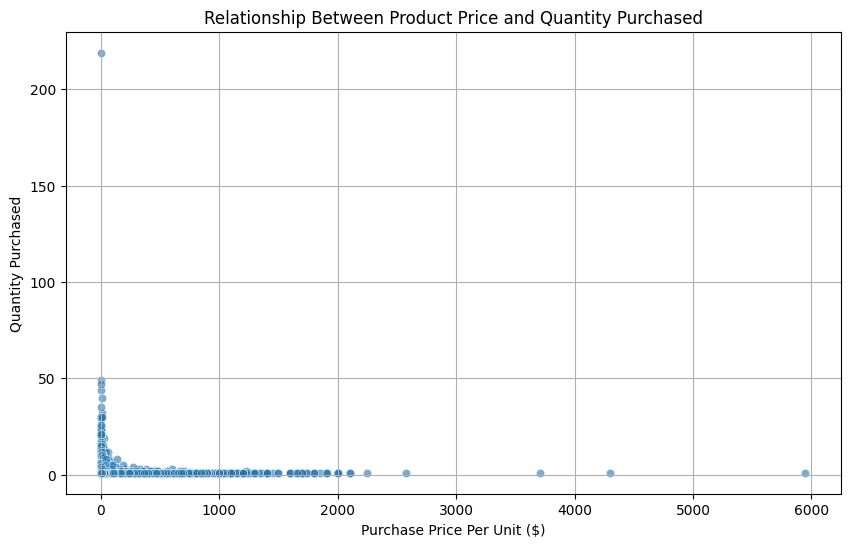

In [42]:
# Plotting relationship Between Price and Quantity

plt.figure(figsize=(10, 6))

sns.scatterplot(x='Purchase Price Per Unit', y='Quantity', data=price_quant_pd, alpha=0.6)

plt.title('Relationship Between Product Price and Quantity Purchased')
plt.xlabel('Purchase Price Per Unit ($)')
plt.ylabel('Quantity Purchased')
plt.grid(True)
plt.show()

Above pair-plot graph shows the relationship between Price and Quantity.

## 3.9 Analyse the spending KPIs <font color = red>[5 marks]</font> <br>


A popular KPI is average spend per customer. Calculate this metric as the ratio of total transaction amount from non-recurring payments divided by the total number of customers who made a purchase

In [43]:
# Average Spend per Customer

from pyspark.sql.functions import avg, sum, col

# Calculate total spend per customer
cust_spend_df = merged_data.groupBy("Survey ResponseID") \
    .agg(sum(col("Purchase Price Per Unit") * col("Quantity")).alias("Total Spend"))

# Calculate the average spend
avg_spend_df = cust_spend_df.agg(avg("Total Spend").alias("Average Spend Per Customer"))

# Show the result
avg_spend_df.show()

+--------------------------+
|Average Spend Per Customer|
+--------------------------+
|         8222.850510948885|
+--------------------------+



In [44]:
# Convert to Pandas for visualisation

cust_spend_pd = cust_spend_df.toPandas()
avg_spend_pd = avg_spend_df.toPandas()

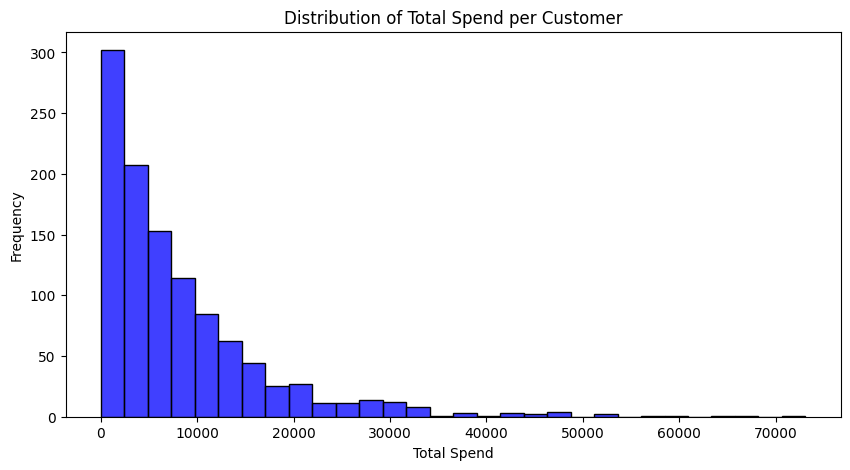

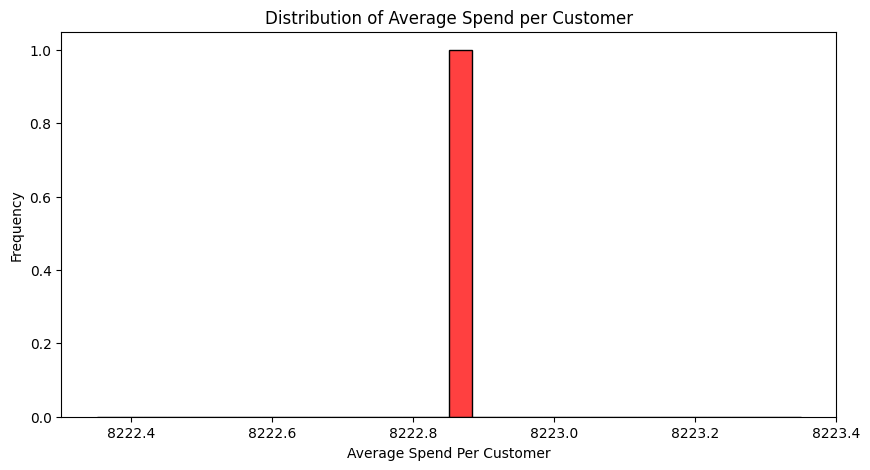

In [45]:
# Plot Distribution of Total Spend per customer

plt.figure(figsize=(10, 5))

sns.histplot(cust_spend_pd["Total Spend"], bins=30, color='blue')
plt.title("Distribution of Total Spend per Customer")
plt.xlabel("Total Spend")
plt.ylabel("Frequency")
plt.show()


# Plot Distribution of Average Spend per customer

plt.figure(figsize=(10, 5))

sns.histplot(avg_spend_pd["Average Spend Per Customer"], bins=30, color='red')
plt.title("Distribution of Average Spend per Customer")
plt.xlabel("Average Spend Per Customer")
plt.ylabel("Frequency")
plt.show()

The spending KPIs (Average Spending Per Customer) for E-commerce Company was found to be around 8222.85.

Analyse the Repeat Purchase Behavior of Customers

In [46]:
# Repeat Purchase Analysis Behavior Per Customers

# Group by Survey ResponseID and count the number of purchases
repeat_pur_df = merged_data.groupBy("Survey ResponseID") \
    .agg(count("*").alias("PurchaseCount"))

# Classify as Repeat or Single Purchase
repeat_pur_df = repeat_pur_df.withColumn("PurchaseCategory",when(col("PurchaseCount") > 1, "Repeat Purchase").otherwise("Single Purchase"))

# Calculate the total count for each category
pur_behv_df = repeat_pur_df.groupBy("PurchaseCategory").agg(count("Survey ResponseID").alias("ResponseCount"))

pur_behv_df.show()

+----------------+-------------+
|PurchaseCategory|ResponseCount|
+----------------+-------------+
| Single Purchase|            1|
| Repeat Purchase|         1095|
+----------------+-------------+



In [47]:
# Convert to Pandas for visualisation

pur_behv_pd = pur_behv_df.toPandas()

<ipython-input-48-12bb9f904928>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="PurchaseCategory", y="ResponseCount", data=pur_behv_pd, palette="viridis")


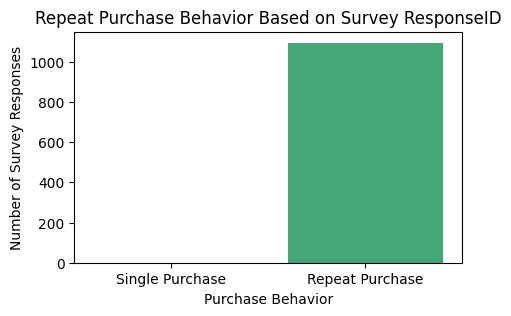

In [48]:
# Plot the Repeat Purchase Behaviour of Customer

plt.figure(figsize=(5, 3))

sns.barplot(x="PurchaseCategory", y="ResponseCount", data=pur_behv_pd, palette="viridis")

plt.title("Repeat Purchase Behavior Based on Survey ResponseID")
plt.xlabel("Purchase Behavior")
plt.ylabel("Number of Survey Responses")
plt.show()


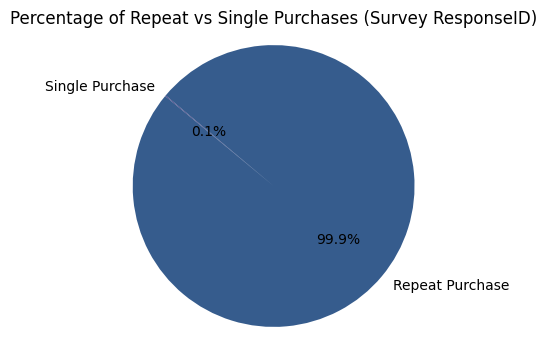

In [49]:
# Plot a Pie Chart for Repeat Purchase Behaviour of Customer

plt.figure(figsize=(4, 4))
plt.pie(pur_behv_pd['ResponseCount'], labels=pur_behv_pd['PurchaseCategory'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis'))
plt.title("Percentage of Repeat vs Single Purchases (Survey ResponseID)")
plt.axis('equal')
plt.show()

A significant portion of customers exhibited Repeat purchase behavior to enhance retention initiatives.

Analyse the top 10 high-engagement customers

In [50]:
# Top 10 High-Engagement Customers

# Lets perform group by with Survey ResponseID and count the no. of purchases for each

high_engage_cust_df = merged_data.groupBy("Survey ResponseID").agg(count("*").alias("PurchaseCount"))

# Lets sort and get top 10 customers

engage_cust_top_10_df = high_engage_cust_df.orderBy(col("PurchaseCount").desc()).limit(10)

engage_cust_top_10_df.show()


+-----------------+-------------+
|Survey ResponseID|PurchaseCount|
+-----------------+-------------+
|R_1QtQEfi1VAWgRM0|         3825|
|R_1PUcgnVG2i0EBz4|         3339|
|R_1NDq0rxoUSu6oyz|         2841|
|R_1NCzj2eSHI4QGcd|         2604|
|R_1C4nKyrv0w2thJn|         2593|
|R_1o4IsRkXnLlSU6K|         2472|
|R_1Iy2gQsVfTKf9TT|         2471|
|R_10CAlrx7dbJty9R|         2420|
|R_1Q9JeeKncbbLcz0|         2343|
|R_1ONsVOpSDE6jAfT|         2244|
+-----------------+-------------+



In [51]:
# Convert to Pandas for visualisation

engage_cust_top_10_pd = engage_cust_top_10_df.toPandas()


<ipython-input-52-155ede40fbc8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Survey ResponseID", y="PurchaseCount", data=engage_cust_top_10_pd, palette="pastel")


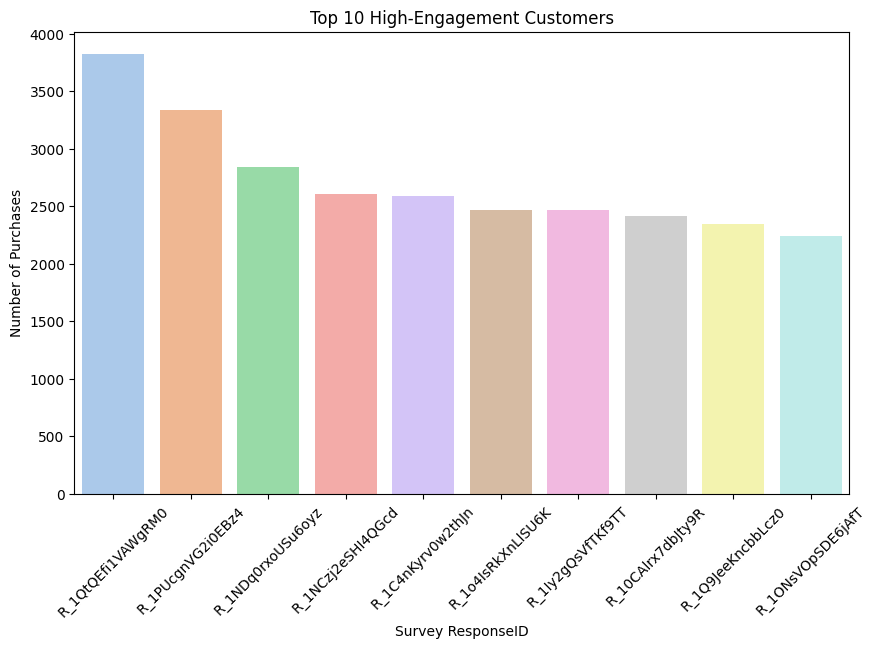

In [52]:
# Plot the Top 10 Engagement customers

plt.figure(figsize=(10, 6))

sns.barplot(x="Survey ResponseID", y="PurchaseCount", data=engage_cust_top_10_pd, palette="pastel")

plt.title("Top 10 High-Engagement Customers")
plt.xlabel("Survey ResponseID")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=45)
plt.show()

Some top customers had high Purchase frequency and must be provided with regular discount and offers for being loyal customer to company.

## 3.10 Seasonal trends in product purchases and their impact on revenues <font color = red>[5 marks]</font> <br>

Investigate the seasonal trends in product purchases and their impact on the overall revenue.

In [53]:
# Seasonal Trends in Product Purchases and Their Impact on Revenue

from pyspark.sql.functions import year

# Extract year and month and calculate Total Revenue (Purchase Price * Quantity)

merged_data = merged_data.withColumn("Year", year("Order Date")).withColumn("Month", month("Order Date"))

merged_data = merged_data.withColumn("Total Revenue", col("Purchase Price Per Unit") * col("Quantity"))

# Group by year and month, summing total revenue

season_trends_rev = merged_data.groupBy("Year", "Month").agg({"Total Revenue": "sum"}).withColumnRenamed("sum(Total Revenue)", "Total Revenue")

season_trends_rev.show()


+----+-----+------------------+
|Year|Month|     Total Revenue|
+----+-----+------------------+
|2022|   10|199782.11000000453|
|2019|   10|101599.26999999967|
|2020|    6|152386.87000000023|
|2019|    5| 95629.31999999989|
|2018|   10| 81052.74000000025|
|2021|    8| 180348.5600000027|
|2021|    6|210050.37000000407|
|2019|    3| 90588.33999999991|
|2021|    5|201137.43000000436|
|2021|   10|182924.47000000323|
|2020|   11|194121.60000000347|
|2020|    3|127374.88999999895|
|2018|    1| 86276.22000000023|
|2018|    3| 77048.01000000042|
|2020|    9| 150067.1299999999|
|2018|    8| 95416.85999999981|
|2022|    2|169263.15000000177|
|2019|    8| 98537.31999999976|
|2022|    7|226684.16000000527|
|2021|   11| 227941.2800000052|
+----+-----+------------------+
only showing top 20 rows



In [54]:
# Convert to Pandas for visualisation

season_trends_rev_pd = season_trends_rev.toPandas()

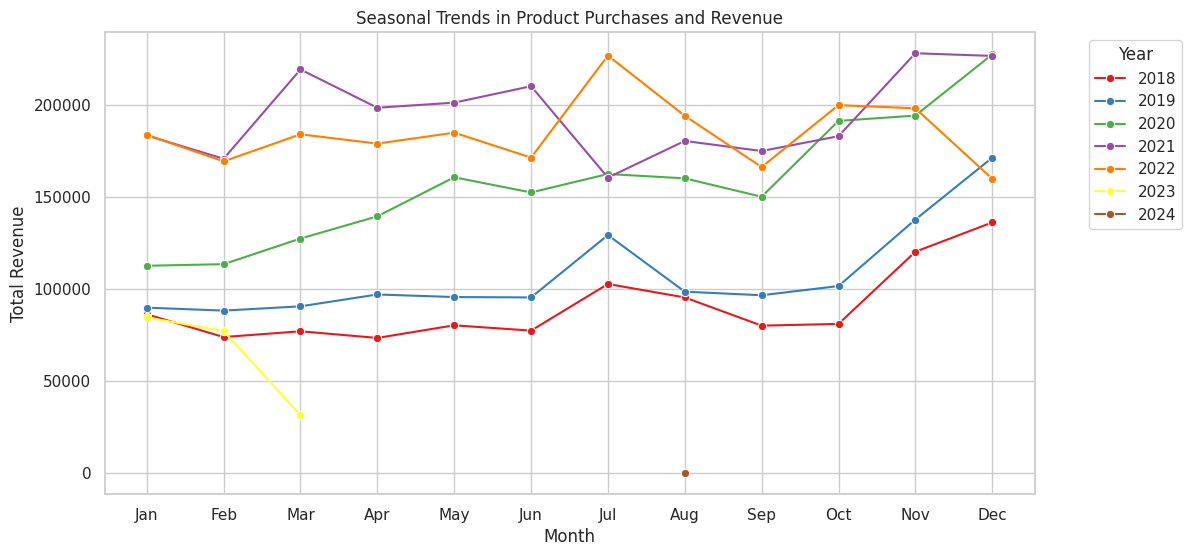

In [55]:
# Plot Total Revenue by Year and Month

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(data=season_trends_rev_pd, x="Month", y="Total Revenue", hue="Year", marker="o", palette="Set1")

plt.title("Seasonal Trends in Product Purchases and Revenue")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.xticks(ticks=range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

The overall Seasonal Purchase trends were mostly found high in Year '2021'and '2020'.

## 3.11 Customer location vs purchasing behavior <font color = red>[5 marks]</font> <br>

Examine the relationship between customer's location and their purchasing behaviors

In [56]:
# Relationship Between Customer Location and Purchase Behavior

# Group purchases by state and total spend

state_spend_data = merged_data.groupBy("Shipping Address State").agg(sum("Total Revenue").alias("Total Spend")) \
                          .orderBy(col("Total Spend").desc())


In [57]:
# Convert to Pandas for visualisation

state_spend_data_pd = state_spend_data.toPandas()

<ipython-input-58-7da525d4f9d5>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_spend_data_pd, x="Total Spend", y="Shipping Address State", palette="plasma")


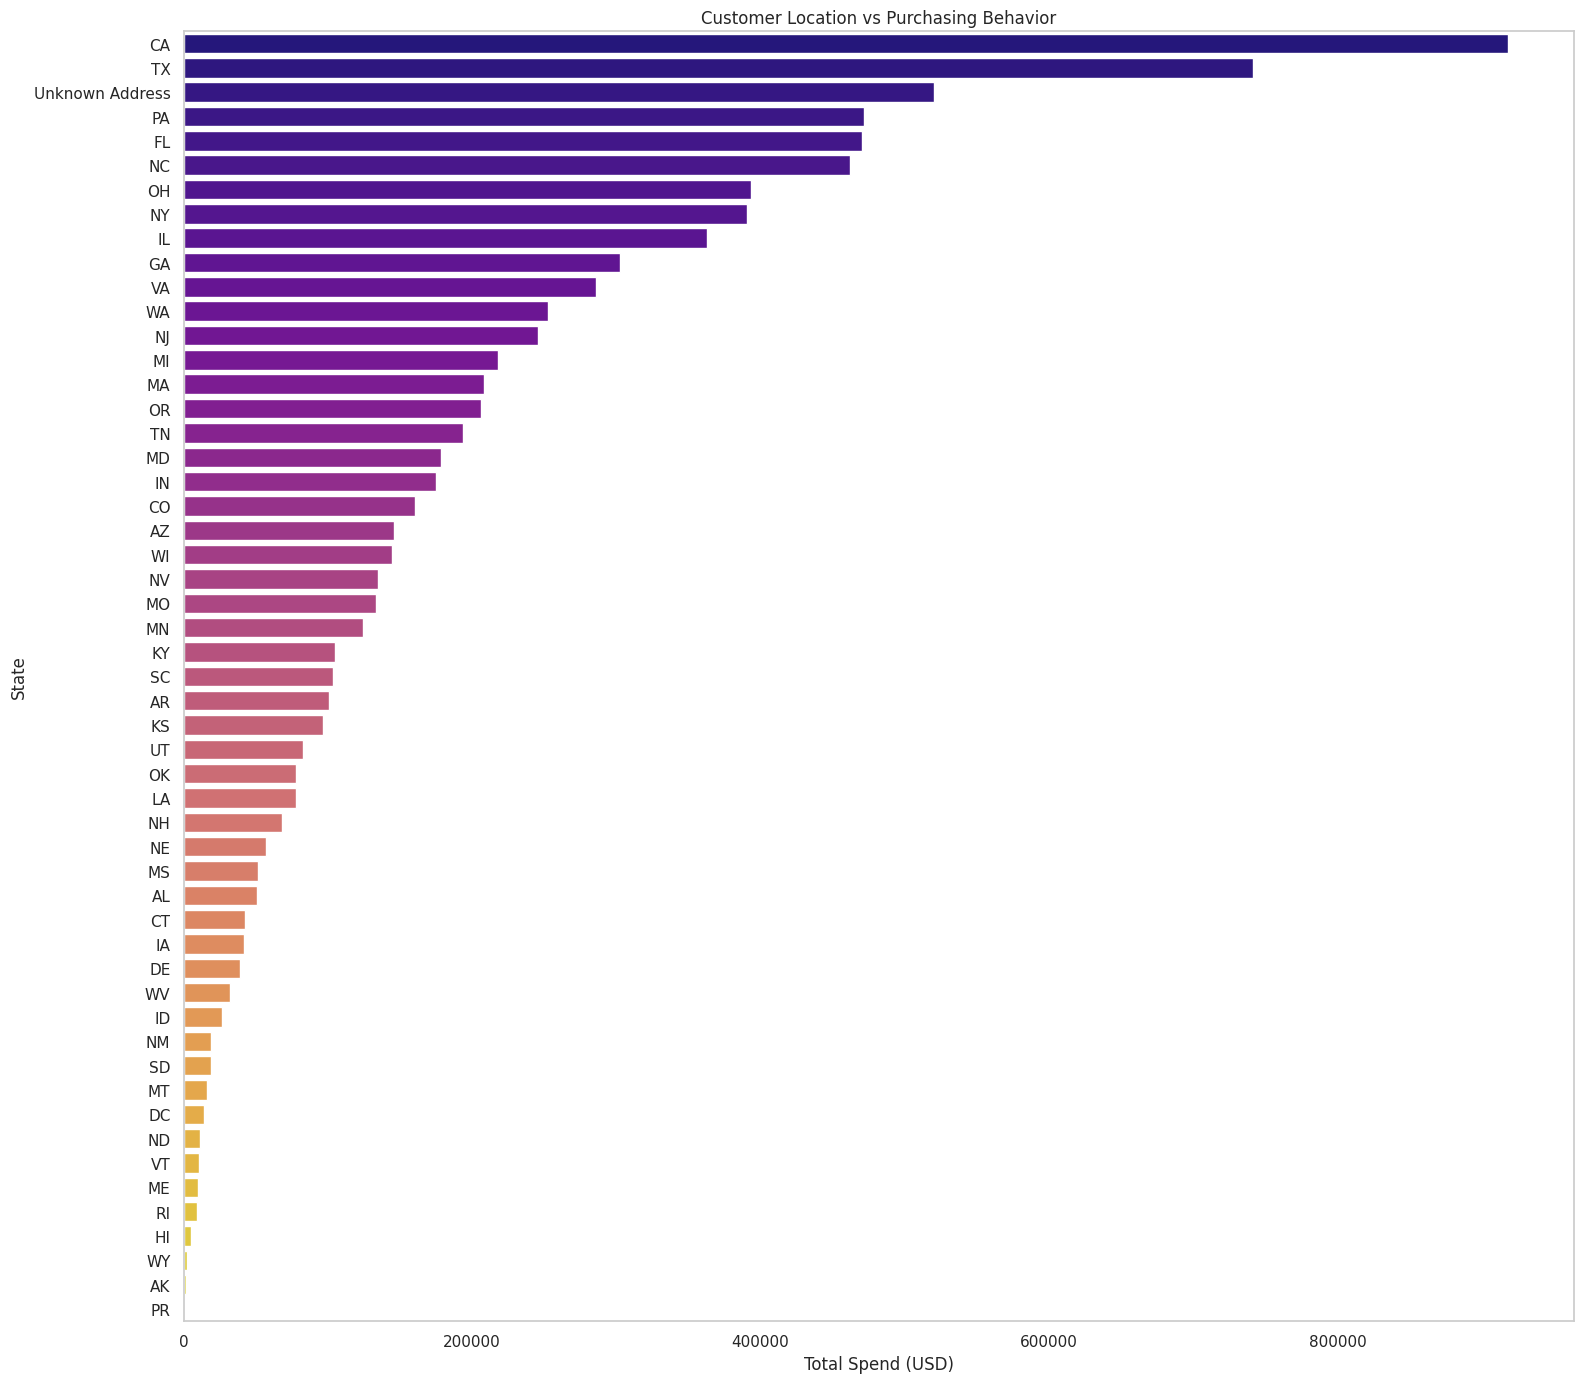

In [58]:
# Plot revenue by state

plt.figure(figsize=(16,14))
sns.barplot(data=state_spend_data_pd, x="Total Spend", y="Shipping Address State", palette="plasma")

plt.title("Customer Location vs Purchasing Behavior")
plt.xlabel("Total Spend (USD)")
plt.ylabel("State")
plt.grid(axis='x')
plt.tight_layout()

plt.show()

From above graph, Purchasing Behavior as per Location was found highly in State of CA (California) followed by TX (Texas) and many more.

#4. Customer Segmentation and Insights <font color = red>[45 marks]</font> <br>


## 4.1 Perform RFM Analysis <font color = red>[10 marks]</font> <br>

RFM Analysis is a powerful customer segmentation technique used to evaluate and quantify customer value based on three key dimensions:
- **Recency**,
- **Frequency**,
- **Monetary**.

This method is particularly effective in identifying high-value customers, optimizing marketing strategies, and improving customer retention in the e-commerce industry.


### 1. Recency (R)
Recency measures how recently a customer made a purchase Customers who have purchased more recently are more likely to respond to promotions and offers.
- **Application:** By ranking customers based on the number of days since their last transaction, you can prioritize those who are most engaged.

### 2. Frequency (F)
Frequency counts the number of purchases a customer has made over a given period.
Frequent purchasers tend to be more loyal and are often a source of recurring revenue.
- **Application:** Analyzing purchase frequency helps in identifying consistent buyers and understanding their buying patterns.

### 3. Monetary (M)
Monetary value represents the total amount of money a customer has spent.
Customers who spend more are often more profitable, making them ideal targets for retention and upsell strategies.
- **Application:** By assessing the monetary contribution, you can distinguish between high-value and low-value customers.


### Prepare data for RFM Analysis <font color = red>[2 marks]</font> <br>


In [59]:
from pyspark.sql.functions import datediff, max, count, sum, lit

# Lets convert 'Order Date' is in date format if not already

merged_data = merged_data.withColumn("Order Date", col("Order Date").cast("date"))

# Get the latest order date in the dataset

order_date_latest = merged_data.agg(max("Order Date")).collect()[0][0]

print(f"Latest Order Date: {order_date_latest}")


Latest Order Date: 2024-08-15


Calculate RFM metrics :

-> Recency: Days since the most recent purchase

-> Frequency: Total number of purchases per customer

-> Monetary: Total spend by each customer

In [60]:
# Calculate RFM metrics

rfm_metrics_data = merged_data.groupBy("Survey ResponseID").agg(
        datediff(lit(order_date_latest), max("Order Date")).alias("Recency"),
        count("Order Date").alias("Frequency"),
        sum(col("Purchase Price Per Unit") * col("Quantity")).alias("Monetary")
    )

rfm_metrics_data.show(10)

+-----------------+-------+---------+------------------+
|Survey ResponseID|Recency|Frequency|          Monetary|
+-----------------+-------+---------+------------------+
|R_10TV1zyi4yCEEkl|    525|     1124|29788.359999999895|
|R_1CqGMkfiCiATbn4|    528|      183| 5691.149999999994|
|R_1LBvKYfg8hgoloJ|   1896|        7|326.78000000000003|
|R_1mxX9jjBSLwxiDU|    524|      248| 2765.260000000001|
|R_1jO4s7oht3pyKEc|    518|      628| 13287.82999999995|
|R_1eWdieBjoYJXAYv|    606|      965|  27099.9699999999|
|R_1NfYBCMTmzHgXGh|    640|        3|47.919999999999995|
|R_1N52McSjcCnVqIm|    590|       11|            267.72|
|R_1gG5xibh48txT6f|    523|      611|13311.659999999943|
|R_1esG9Jlh9NISLaO|    529|      368| 6881.199999999989|
+-----------------+-------+---------+------------------+
only showing top 10 rows



In [61]:
# Filter out customers with no purchases

rfm_metrics_data = rfm_metrics_data.filter((col("Frequency") > 0) & (col("Monetary") > 0))

# Show RFM data

rfm_metrics_data.show(10)

+-----------------+-------+---------+------------------+
|Survey ResponseID|Recency|Frequency|          Monetary|
+-----------------+-------+---------+------------------+
|R_10TV1zyi4yCEEkl|    525|     1124|29788.359999999895|
|R_1CqGMkfiCiATbn4|    528|      183| 5691.149999999994|
|R_1LBvKYfg8hgoloJ|   1896|        7|326.78000000000003|
|R_1mxX9jjBSLwxiDU|    524|      248| 2765.260000000001|
|R_1jO4s7oht3pyKEc|    518|      628| 13287.82999999995|
|R_1eWdieBjoYJXAYv|    606|      965|  27099.9699999999|
|R_1NfYBCMTmzHgXGh|    640|        3|47.919999999999995|
|R_1N52McSjcCnVqIm|    590|       11|            267.72|
|R_1gG5xibh48txT6f|    523|      611|13311.659999999943|
|R_1esG9Jlh9NISLaO|    529|      368| 6881.199999999989|
+-----------------+-------+---------+------------------+
only showing top 10 rows



In [62]:
from pyspark.sql.functions import log1p

# Apply log transformation to skewed features i.e log1p (log(1 + x)) to avoid log(0) issues

rfm_metrics_data = rfm_metrics_data.withColumn("Log_Recency", log1p("Recency")) \
                    .withColumn("Log_Frequency", log1p("Frequency")) \
                    .withColumn("Log_Monetary", log1p("Monetary"))


In [63]:
# Convert to Pandas DataFrame (for scikit-learn compatibility)

rfm_pd = rfm_metrics_data.select("Log_Recency", "Log_Frequency", "Log_Monetary").toPandas()

In [64]:
# Scale features using StandardScaler

import pandas as pd
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features_data = scaler.fit_transform(rfm_pd)

# Convert to Pandas DataFrame

scaled_rfm_metrics_df = pd.DataFrame(scaled_features_data, columns=["Log_Recency", "Log_Frequency", "Log_Monetary"])

# Show Data

scaled_rfm_metrics_df.head()

,Log_Recency,Log_Frequency,Log_Monetary
0,-0.548014,1.411101,1.482972
1,-0.526816,-0.032818,0.190963
2,4.232953,-2.533312,-2.037376
3,-0.555106,0.208433,-0.372341
4,-0.597948,0.947441,0.852818


In [65]:
from sklearn.cluster import KMeans

# Calculate the Within-Cluster Sum of Squares (WCSS)

wcss = []

# Test different numbers of clusters (1 to 10)
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_rfm_metrics_df)
    wcss.append(kmeans.inertia_)


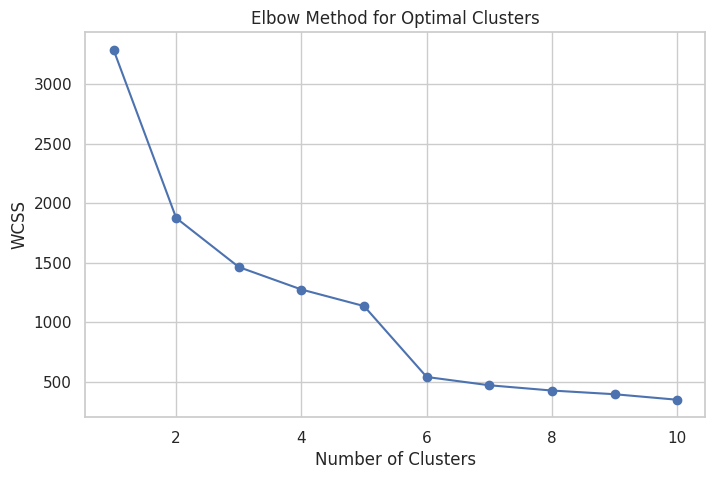

In [66]:
# Plot the elbow curve with the number of clusters on the x-axis and WCSS on the y-axis

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

From above graph, the most noticeable change in slope occurs at **6 clusters**:

-> Before 6 clusters, WCSS decreases rapidly.

-> After 6 clusters, the reduction slows down significantly.

Conclusion:

The optimal number of clusters is **6**, as it represents the elbow point where adding more clusters provides less substantial improvement in WCSS.

In [67]:
# Fit the K-Means model using the optimal number of clusters obtained after understanding the elblow plot

opt_clust = 6  # optimal number of clusters

kmeans = KMeans(n_clusters=opt_clust, init='k-means++', random_state=42)

rfm_clusters = kmeans.fit_predict(scaled_rfm_metrics_df)

In [68]:
# Add the assigned cluster labels to the Pandas DataFrame and convert back to PySpark if needed

rfm_pd['Cluster'] = rfm_clusters

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

rfm_spark_df = spark.createDataFrame(rfm_pd)
rfm_spark_df.show(5)

+------------------+------------------+------------------+-------+
|       Log_Recency|     Log_Frequency|      Log_Monetary|Cluster|
+------------------+------------------+------------------+-------+
|  6.26530121273771| 7.025538314638521|10.301906561757177|      4|
| 6.270988431858299| 5.214935757608986| 8.646843311638339|      2|
|7.5480289699350145|2.0794415416798357| 5.792342651635681|      1|
| 6.263398262591624| 5.517452896464707| 7.925251506360985|      2|
| 6.251903883165888| 6.444131256700441| 9.494679111714499|      4|
+------------------+------------------+------------------+-------+
only showing top 5 rows



In [69]:
# Convert the full RFM dataset from PySpark DataFrame to Pandas DataFrame for visualisation

rfm_pd = rfm_spark_df.toPandas()

# Display the first few rows
rfm_pd.head()


,Log_Recency,Log_Frequency,Log_Monetary,Cluster
0,6.265301,7.025538,10.301907,4
1,6.270988,5.214936,8.646843,2
2,7.548029,2.079442,5.792343,1
3,6.263398,5.517453,7.925252,2
4,6.251904,6.444131,9.494679,4


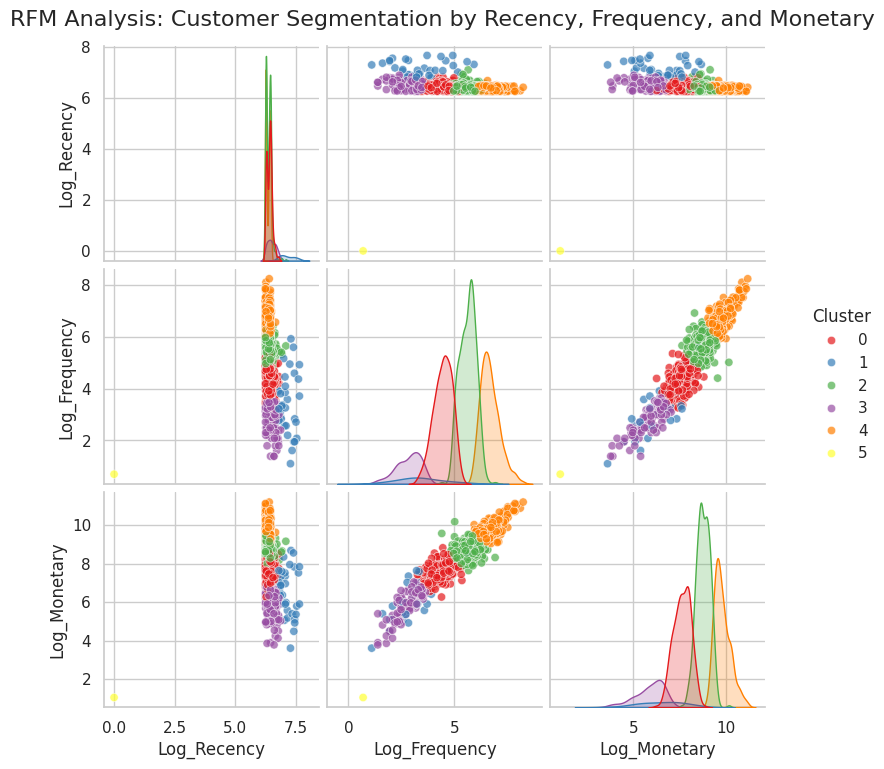

In [70]:
# Generate a pairplot to visualise the relationships between the numeric RFM columns

sns.pairplot(rfm_pd, hue='Cluster', palette='Set1', plot_kws={'alpha': 0.7})

plt.suptitle('RFM Analysis: Customer Segmentation by Recency, Frequency, and Monetary', size=16, y=1.02)
plt.show()


### Behavioral Trends Analysis <font color = red>[8 marks]</font> <br>

Perform RFM analysis to study the behavior of customers to tailor marketing strategies

In [71]:
# Import necessary PySpark functions for data processing

from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from datetime import datetime


# Lets convert column "Order Date" to Date format, if not already
df = merged_data.withColumn('Order Date', F.to_date(merged_data['Order Date'], 'yyyy-MM-dd'))

# Lets get today's date for Recency calculation
today = datetime.today().strftime('%Y-%m-%d')
today_date = F.lit(today)


# Group the dataset by 'Survey ResponseID' to calculate RFM (Recency, Frequency, Monetary) metrics

rfm_metrics_df = df.groupBy('Survey ResponseID').agg(
    # Compute 'Recency' as the difference between the latest date and the most recent order date
    (F.datediff(today_date, F.max('Order Date'))).alias('Recency'),

    # Compute 'Frequency' as the count of distinct product purchases (ASIN/ISBN)
    F.countDistinct('ASIN/ISBN (Product Code)').alias('Frequency'),

    # Compute 'Monetary' as the total spending sum for each customer
    F.sum('Purchase Price Per Unit').alias('Monetary')
)

# Display the result of RFM computation
rfm_metrics_df.show(5)


+-----------------+-------+---------+------------------+
|Survey ResponseID|Recency|Frequency|          Monetary|
+-----------------+-------+---------+------------------+
|R_10TV1zyi4yCEEkl|    756|     1051|29335.509999999915|
|R_1jO4s7oht3pyKEc|    749|      564|12975.219999999947|
|R_1gG5xibh48txT6f|    754|      584|13084.279999999955|
|R_1esG9Jlh9NISLaO|    760|      347| 6814.449999999986|
|R_1li5HiNnFHiD7yw|    764|      130| 3317.170000000001|
+-----------------+-------+---------+------------------+
only showing top 5 rows



In [72]:
# Rename columns if required and normlise the distributions (Recency, Frequency, Monetary)

rfm_metrics_df = rfm_metrics_df.withColumnRenamed('Survey ResponseID', 'CustomerID')

# Use log transformation for skewed distributions

from pyspark.sql.functions import log1p

rfm_metrics_df = rfm_metrics_df.withColumn('LogRecency', log1p('Recency'))
rfm_metrics_df = rfm_metrics_df.withColumn('LogFrequency', log1p('Frequency'))
rfm_metrics_df = rfm_metrics_df.withColumn('LogMonetary', log1p('Monetary'))

rfm_metrics_df.show(5)

+-----------------+-------+---------+------------------+------------------+------------------+------------------+
|       CustomerID|Recency|Frequency|          Monetary|        LogRecency|      LogFrequency|       LogMonetary|
+-----------------+-------+---------+------------------+------------------+------------------+------------------+
|R_10TV1zyi4yCEEkl|    756|     1051|29335.509999999915|6.6293632534374485|6.9584483932976555|10.286588094383246|
|R_1jO4s7oht3pyKEc|    749|      564|12975.219999999947| 6.620073206530356| 6.336825731146441| 9.470873730588778|
|R_1gG5xibh48txT6f|    754|      584|13084.279999999955| 6.626717749249025| 6.371611847231857| 9.479243213283253|
|R_1esG9Jlh9NISLaO|    760|      347| 6814.449999999986| 6.634633357861686|5.8522024797744745| 8.826947372765073|
|R_1li5HiNnFHiD7yw|    764|      130| 3317.170000000001| 6.639875833826536| 4.875197323201151| 8.107168705122035|
+-----------------+-------+---------+------------------+------------------+-------------

In [73]:
# Convert the processed RFM dataset back to Pandas for sklearn compatibility for clustering

rfm_pd = rfm_metrics_df.toPandas()

# Display the first few rows of the Pandas DataFrame

print(rfm_pd.head())

          CustomerID  Recency  Frequency  Monetary  LogRecency  LogFrequency  \
0  R_10TV1zyi4yCEEkl      756       1051  29335.51    6.629363      6.958448   
1  R_1jO4s7oht3pyKEc      749        564  12975.22    6.620073      6.336826   
2  R_1gG5xibh48txT6f      754        584  13084.28    6.626718      6.371612   
3  R_1esG9Jlh9NISLaO      760        347   6814.45    6.634633      5.852202   
4  R_1li5HiNnFHiD7yw      764        130   3317.17    6.639876      4.875197   

   LogMonetary  
0    10.286588  
1     9.470874  
2     9.479243  
3     8.826947  
4     8.107169  


In [74]:
# Apply K-Means clustering

# Convert the RFM PySpark DataFrame to Pandas for K-Means (use only numerical features for clustering)
rfm_pd = rfm_metrics_df.toPandas()

# Standardize the RFM features (Recency, Frequency, Monetary) using StandardScaler

scaler = StandardScaler()
scaled_rfm = scaler.fit_transform(rfm_pd[['Recency', 'Frequency', 'Monetary']])


In [75]:
# Fit the K-Means model and predict cluster labels for each customer

kmeans = KMeans(n_clusters=5, random_state=42)

# Add the predicted cluster labels to the Pandas DataFrame

rfm_pd['Cluster'] = kmeans.fit_predict(scaled_rfm)

# Convert the Pandas DataFrame back to a PySpark DataFrame

rfm_spark_df = spark.createDataFrame(rfm_pd)

# Show the data of PySpark DataFrame

rfm_spark_df.show(5)

+-----------------+-------+---------+------------------+------------------+------------------+------------------+-------+
|       CustomerID|Recency|Frequency|          Monetary|        LogRecency|      LogFrequency|       LogMonetary|Cluster|
+-----------------+-------+---------+------------------+------------------+------------------+------------------+-------+
|R_10TV1zyi4yCEEkl|    756|     1051|29335.509999999915|6.6293632534374485|6.9584483932976555|10.286588094383246|      1|
|R_1jO4s7oht3pyKEc|    749|      564|12975.219999999947| 6.620073206530356| 6.336825731146441| 9.470873730588778|      4|
|R_1gG5xibh48txT6f|    754|      584|13084.279999999955| 6.626717749249025| 6.371611847231857| 9.479243213283253|      4|
|R_1esG9Jlh9NISLaO|    760|      347| 6814.449999999986| 6.634633357861686|5.8522024797744745| 8.826947372765073|      4|
|R_1li5HiNnFHiD7yw|    764|      130| 3317.170000000001| 6.639875833826536| 4.875197323201151| 8.107168705122035|      0|
+-----------------+-----

Analyse the Cluster Distribution by Income <font color = red>[2 marks]</font> <br>


In [76]:
print(rfm_spark_df.columns)
print(survey.columns)

['CustomerID', 'Recency', 'Frequency', 'Monetary', 'LogRecency', 'LogFrequency', 'LogMonetary', 'Cluster']
['Survey ResponseID', 'Q-demos-age', 'Q-demos-hispanic', 'Q-demos-race', 'Q-demos-education', 'Q-demos-income', 'Q-demos-gender', 'Q-sexual-orientation', 'Q-demos-state', 'Q-amazon-use-howmany', 'Q-amazon-use-hh-size', 'Q-amazon-use-how-oft', 'Q-substance-use-cigarettes', 'Q-substance-use-marijuana', 'Q-substance-use-alcohol', 'Q-personal-diabetes', 'Q-personal-wheelchair', 'Q-life-changes', 'Q-sell-YOUR-data', 'Q-sell-consumer-data', 'Q-small-biz-use', 'Q-census-use', 'Q-research-society']


In [77]:
#Trend 1: Cluster Distribution by Income

# Import the necessary function for counting records in PySpark

from pyspark.sql.functions import col

# Join the RFM dataset with the survey dataset using a common key

rfm_income = rfm_spark_df.join(survey, rfm_spark_df['CustomerID'] == survey['Survey ResponseID'], how='inner')

# Aggregate data to count the number of customers per Cluster-Income group

cluster_income_distribute = rfm_income.groupBy('Cluster', 'Q-demos-income') \
                                              .count() \
                                              .orderBy('Cluster', 'Q-demos-income')

# Display data

cluster_income_distribute.show()

+-------+-------------------+-----+
|Cluster|     Q-demos-income|count|
+-------+-------------------+-----+
|      0|$100,000 - $149,999|   71|
|      0|   $150,000 or more|   34|
|      0|  $25,000 - $49,999|  158|
|      0|  $50,000 - $74,999|  121|
|      0|  $75,000 - $99,999|   94|
|      0|  Less than $25,000|  118|
|      0|  Prefer not to say|    8|
|      1|$100,000 - $149,999|   29|
|      1|   $150,000 or more|   12|
|      1|  $25,000 - $49,999|   15|
|      1|  $50,000 - $74,999|   25|
|      1|  $75,000 - $99,999|   20|
|      1|  Less than $25,000|    3|
|      1|  Prefer not to say|    1|
|      2|$100,000 - $149,999|    8|
|      2|   $150,000 or more|    2|
|      2|  $50,000 - $74,999|    7|
|      2|  $75,000 - $99,999|    5|
|      3|$100,000 - $149,999|    3|
|      3|   $150,000 or more|    1|
+-------+-------------------+-----+
only showing top 20 rows



In [78]:
# Convert the aggregated data from PySpark DataFrame to Pandas DataFrame for visualisation

cluster_income_pd = cluster_income_distribute.toPandas()

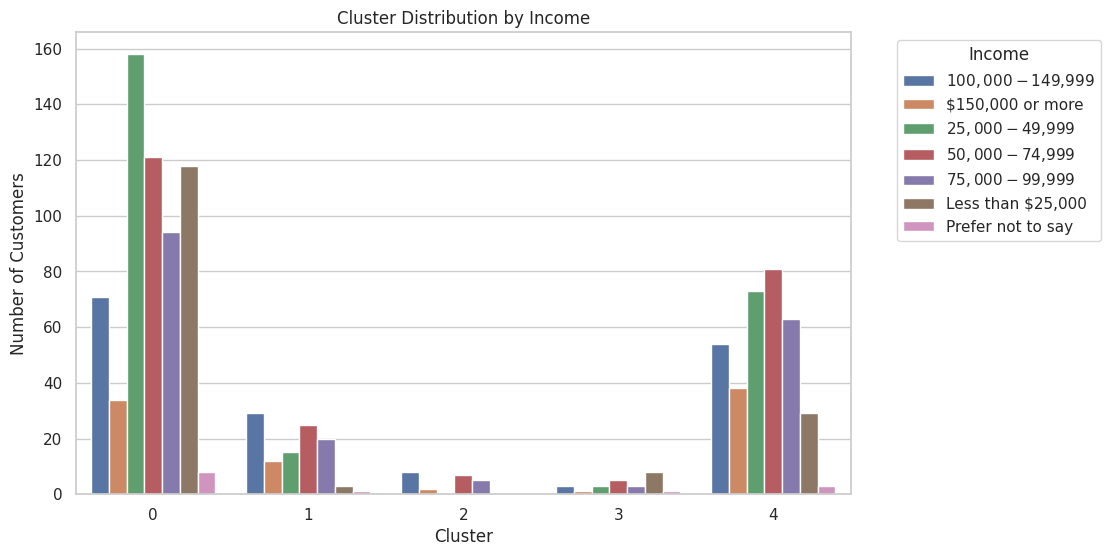

In [79]:
# Plot the Cluster Distribution by Income

plt.figure(figsize=(10, 6))

sns.barplot(data=cluster_income_pd, x='Cluster', y='count', hue='Q-demos-income')

plt.title('Cluster Distribution by Income')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.legend(title='Income', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Cluster Distribution by Income was high for Cluster 0 in which Highest number of customers were of Income range $25,000-49,999.

Analyse the Average Spending by Cluster <font color = red>[2 marks]</font> <br>


In [80]:
#Trend 2: Average Spending by Cluster

# Import the required function for calculating averages in PySpark

from pyspark.sql import functions as F

# Compute the average values of 'Recency_log', 'Frequency', and 'Monetary_log' for each customer cluster

cluster_avg_spend = rfm_income.groupBy("Cluster").agg(
    F.avg("LogRecency").alias("Avg_LogRecency"),
    F.avg("Frequency").alias("Avg_Frequency"),
    F.avg("LogMonetary").alias("Avg_LogMonetary")
)

In [81]:
# Convert the aggregated cluster summary from PySpark DataFrame to Pandas DataFrame for visualisation

cluster_avg_spend_pd = cluster_avg_spend.toPandas()

# Show data

cluster_avg_spend_pd.head()

,Cluster,Avg_LogRecency,Avg_Frequency,Avg_LogMonetary
0,0,6.747077,107.923841,7.606054
1,1,6.684830,846.171429,9.975673
2,3,7.450088,68.083333,6.466484
3,2,6.678045,1793.000000,10.701526
4,4,6.698363,393.217009,9.202757


<ipython-input-82-0d8d8e4d3068>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Cluster", y="Avg_LogMonetary", data=cluster_avg_spend_pd, palette="Set1")


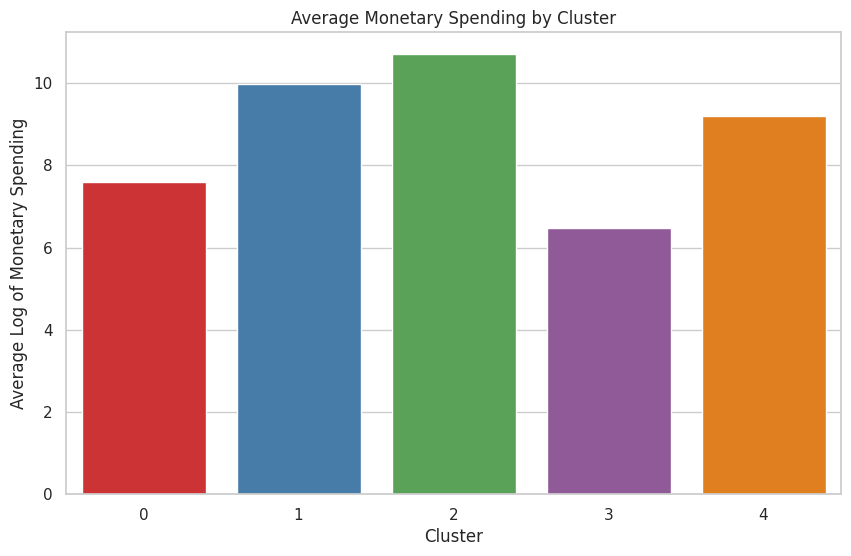

In [82]:
# Generate a bar plot to visualise the average monetary spending per cluster

plt.figure(figsize=(10, 6))

sns.barplot(x="Cluster", y="Avg_LogMonetary", data=cluster_avg_spend_pd, palette="Set1")

plt.title("Average Monetary Spending by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Log of Monetary Spending")
plt.show()

The Average Monetary Spending by Cluster was high in Cluster 2.

Analyse the Purchase Frequency vs. Recency <font color = red>[2 marks]</font> <br>


<ipython-input-83-a1195c807734>:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="Frequency", y="Recency", data=rfm_pd, palette="viridis")


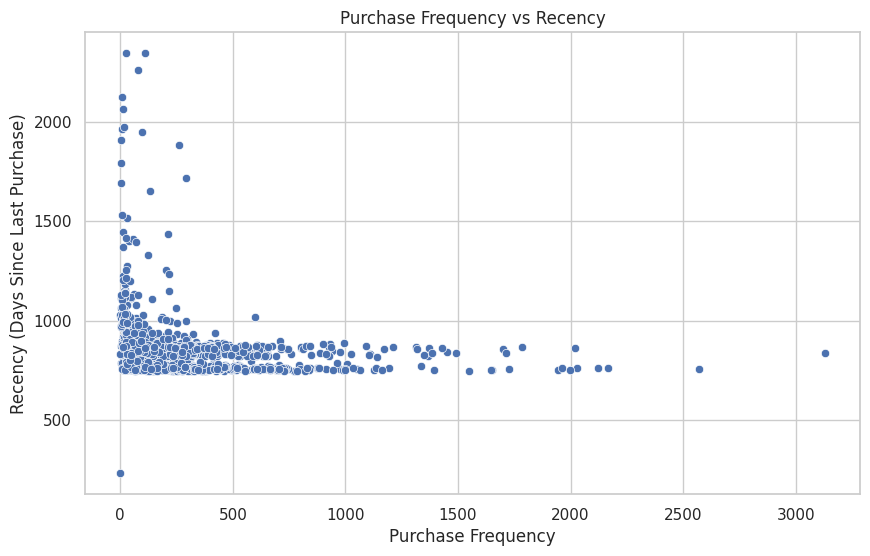

In [83]:
#Trend 3: Purchase Frequency vs. Recency

# Convert the RFM dataset from PySpark DataFrame to Pandas DataFrame for visualisation

rfm_pd = rfm_metrics_df.toPandas()

# Generate a scatter plot to analyse the relationship between Purchase Frequency and Recency

plt.figure(figsize=(10, 6))

sns.scatterplot(x="Frequency", y="Recency", data=rfm_pd, palette="viridis")

plt.title("Purchase Frequency vs Recency")
plt.xlabel("Purchase Frequency")
plt.ylabel("Recency (Days Since Last Purchase)")
plt.show()

Above pair-plot shows the relationship between Purchase Frequency and Recency.

In [84]:
print(rfm_metrics_df.columns)
print(merged_data.columns)

['CustomerID', 'Recency', 'Frequency', 'Monetary', 'LogRecency', 'LogFrequency', 'LogMonetary']
['Survey ResponseID', 'Order Date', 'Purchase Price Per Unit', 'Quantity', 'Shipping Address State', 'Title', 'ASIN/ISBN (Product Code)', 'Category', 'Q-demos-age', 'Q-demos-hispanic', 'Q-demos-race', 'Q-demos-education', 'Q-demos-income', 'Q-demos-gender', 'Q-sexual-orientation', 'Q-demos-state', 'Q-amazon-use-howmany', 'Q-amazon-use-hh-size', 'Q-amazon-use-how-oft', 'Q-substance-use-cigarettes', 'Q-substance-use-marijuana', 'Q-substance-use-alcohol', 'Q-personal-diabetes', 'Q-personal-wheelchair', 'Q-life-changes', 'Q-sell-YOUR-data', 'Q-sell-consumer-data', 'Q-small-biz-use', 'Q-census-use', 'Q-research-society', 'Hour', 'DayOfWeek', 'Month', 'YearMonth', 'Day_Type', 'Year', 'Total Revenue']


Analyse the top categories by clusters <font color = red>[2 marks]</font> <br>


In [85]:
#Trend 4: Top Categories by Cluster

# Import the necessary function to calculate the sum in PySpark

from pyspark.sql import functions as F

# Join the merged dataset with the RFM dataset to associate each customer with their respective cluster

merged_rfm_df = merged_data.join(rfm_spark_df, merged_data['Survey ResponseID'] == rfm_spark_df['CustomerID'], how="inner")

# Group the filtered data by 'Category' and compute the total spending in each category

category_spend_df = merged_rfm_df.groupBy('Category', 'Cluster') \
    .agg(F.sum('Purchase Price Per Unit').alias('Total Spending')) \
    .orderBy(F.col('Total Spending').desc())

#Show Data

category_spend_df.show()

+--------------------+-------+------------------+
|            Category|Cluster|    Total Spending|
+--------------------+-------+------------------+
|       Not Specified|      4|200809.71000000526|
|       Not Specified|      1|115352.88999999894|
|           ABIS_BOOK|      4|109262.48999999947|
|       Not Specified|      0|  97545.8399999997|
|           GIFT_CARD|      4| 91024.45999999996|
|           ABIS_BOOK|      0|63050.530000000705|
|            PET_FOOD|      4|60095.980000000534|
|           ABIS_BOOK|      1| 57898.93000000068|
|NUTRITIONAL_SUPPL...|      4| 57287.47000000064|
|       Not Specified|      2| 56699.78000000061|
|           GIFT_CARD|      0|52903.650000000045|
|               SHOES|      4| 52690.08000000025|
|            PET_FOOD|      1| 45862.07000000014|
|               SHIRT|      4|43880.390000000305|
|          HEADPHONES|      4| 43548.11000000022|
|NUTRITIONAL_SUPPL...|      1| 42177.14000000004|
|               PANTS|      4| 36510.64000000002|


In [86]:
# Order the categories by total spending in descending order and select the top 5 highest spending categories

top_5_categories_df = category_spend_df.orderBy(F.desc('Total Spending')).limit(5)

# Show the top 5 categories

top_5_categories_df.show()


+-------------+-------+------------------+
|     Category|Cluster|    Total Spending|
+-------------+-------+------------------+
|Not Specified|      4|200809.71000000526|
|Not Specified|      1|115352.88999999894|
|    ABIS_BOOK|      4|109262.48999999947|
|Not Specified|      0|  97545.8399999997|
|    GIFT_CARD|      4| 91024.45999999996|
+-------------+-------+------------------+



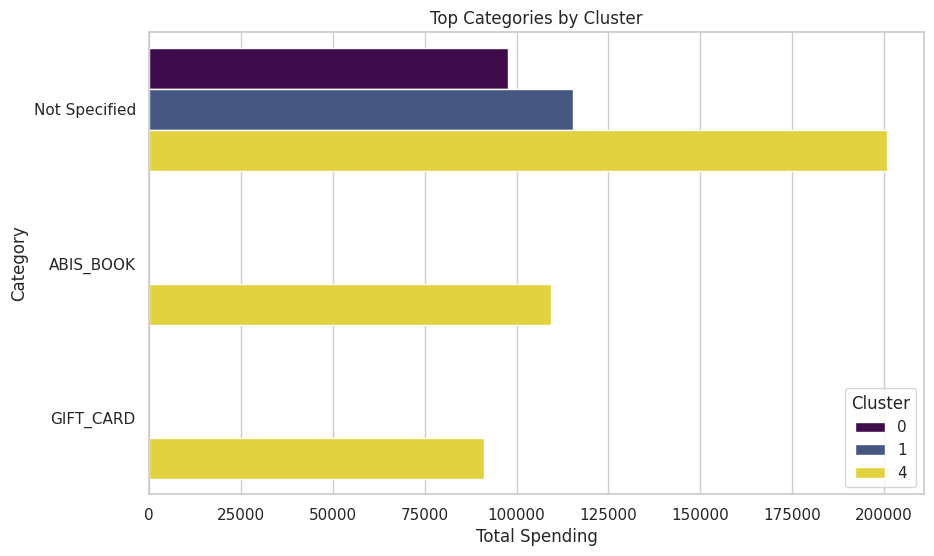

In [87]:
# Convert the top categories dataset from PySpark DataFrame to Pandas DataFrame for visualisation

category_spend_pd = top_5_categories_df.toPandas()


# Plot the cluster

plt.figure(figsize=(10, 6))
sns.barplot(x='Total Spending', y='Category', data=category_spend_pd, hue='Cluster', palette="viridis")
plt.title('Top Categories by Cluster')
plt.xlabel('Total Spending')
plt.ylabel('Category')
plt.legend(title='Cluster')
plt.show()

The Product named “Not Specified” as a Top category showed highest total spending in Cluster 4.

## 4.2 Insights <font color = red>[35 marks]</font> <br>


### 4.2.1 When to schedule effective promotions. <font color = red>[3 marks]</font> <br>

Compare sales across weekdays to schedule effective promotions

In [88]:
#Compare sales across weekdays to schedule effective promotions

from pyspark.sql.functions import dayofweek

# Extract day of the week (1 = Sunday, 7 = Saturday)

wkday_sales_df = merged_data.withColumn('DayOfWeek', dayofweek(merged_data['Order Date']))

# Group by weekday and sum total sales

wkday_sales = wkday_sales_df.groupBy('DayOfWeek').agg(sum('Purchase Price Per Unit').alias('Total Sales'))

# Show data

wkday_sales.show()

+---------+------------------+
|DayOfWeek|       Total Sales|
+---------+------------------+
|        1|1211257.2699997993|
|        6|1203484.0599998129|
|        3|1295261.0999997738|
|        5|1207361.1899998165|
|        4|1240003.3699998031|
|        7|1120682.6899998393|
|        2|1347536.1299997675|
+---------+------------------+



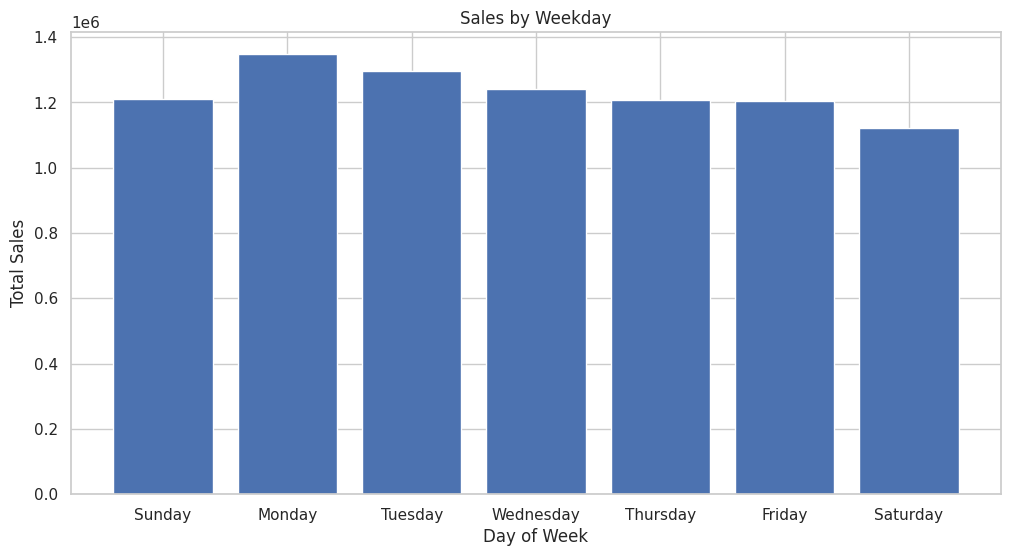

In [89]:
# Convert to Pandas for visualisation

weekday_sales_pd = wkday_sales.toPandas()


# Plot sales by weekday

plt.figure(figsize=(12, 6))
plt.bar(weekday_sales_pd['DayOfWeek'], weekday_sales_pd['Total Sales'])
plt.xlabel('Day of Week')
plt.ylabel('Total Sales')
plt.title('Sales by Weekday')
plt.xticks([1, 2, 3, 4, 5, 6, 7], ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.show()

Sales were high on Monday followed by other weekdays; therefore, effective promotions must be scheduled moreover on weekdays.

### 4.2.2 Top-selling Products <font color = red>[2 marks]</font> <br>

Identify top-selling products by considering revenue and engagement metrics

In [90]:
#Identify top-selling products using revenue and engagement metrics

# Group by product and sum revenue

top_pdt_df = merged_data.groupBy('ASIN/ISBN (Product Code)').agg(
    sum('Purchase Price Per Unit').alias('Total Revenue'),
    sum('Quantity').alias('Total Quantity')
)

# Get top 10 products by revenue

top_10_pdt = top_pdt_df.orderBy('Total Revenue', ascending=False).limit(10)

# Show data

top_10_pdt.show()

+------------------------+------------------+--------------+
|ASIN/ISBN (Product Code)|     Total Revenue|Total Quantity|
+------------------------+------------------+--------------+
|              B00IX1I3G6|48310.640000000014|        1747.0|
|              B086KKT3RX|25062.619999999995|        1031.0|
|              B07PCMWTSG|           9326.36|         255.0|
|              B08F3C99KN|           8743.19|         172.0|
|              B00OTXQT1I| 7983.199999999999|          16.0|
|              B004LLIKVU| 7613.209999999999|         217.0|
|              B074T91QTZ|           7500.34|         201.0|
|              B07HJD9FVV| 7036.299999999997|          36.0|
|              B07ZDX292M|           6506.67|         184.0|
|           Not Available| 6257.919999999988|         322.0|
+------------------------+------------------+--------------+



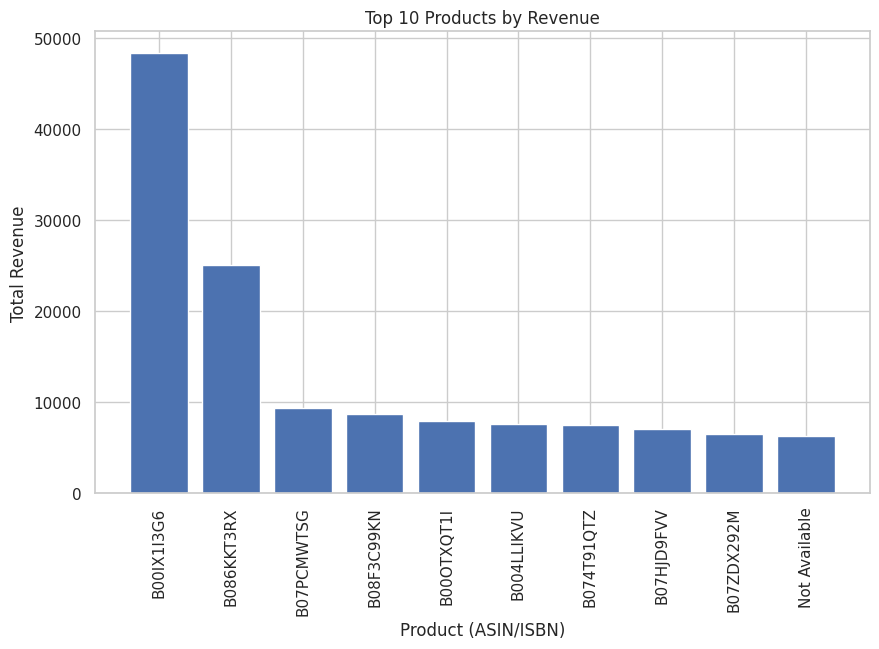

In [91]:
# Convert to Pandas for visualisation

top_10_pdt_pd = top_10_pdt.toPandas()


# Plot top products by revenue

plt.figure(figsize=(10, 6))

plt.bar(top_10_pdt_pd['ASIN/ISBN (Product Code)'], top_10_pdt_pd['Total Revenue'])

plt.xlabel('Product (ASIN/ISBN)')
plt.ylabel('Total Revenue')
plt.title('Top 10 Products by Revenue')
plt.xticks(rotation=90)
plt.show()

The Product code with B00IX1I3G6 followed by some top 10 products can help in revenue growth by increasing their sales.

### 4.2.3 State-wise revenue Distribution <font color = red>[5 marks]</font> <br>

Assess state-wise revenue to focus on high-growth areas

In [92]:
#Assess state-wise revenue to focus on high-growth areas

# Group by state and sum revenue

state_rev_df = merged_data.groupBy('Q-demos-state').agg(sum('Purchase Price Per Unit').alias('Total Revenue'))

# Convert to Pandas for visualisation

state_rev_pd = state_rev_df.toPandas()

# Display Data

state_rev_pd.head()

,Q-demos-state,Total Revenue
0,Utah,67652.78
1,Hawaii,4490.58
2,Minnesota,128453.30
3,Ohio,368278.16
4,Arkansas,120282.22


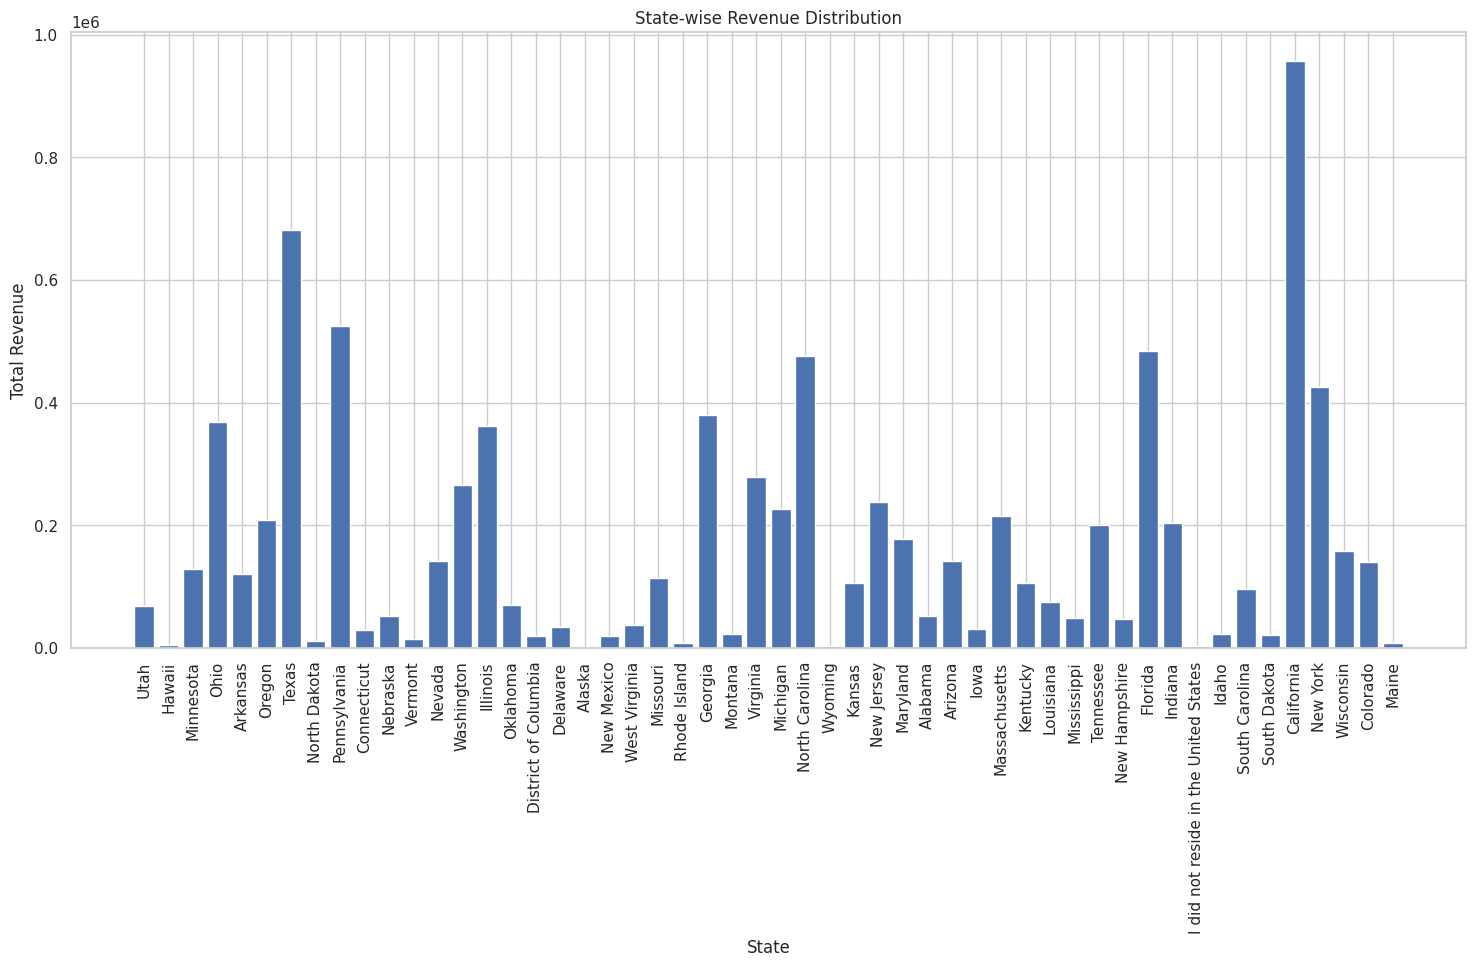

In [93]:
# Plot revenue by state

plt.figure(figsize=(18, 8))

plt.bar(state_rev_pd['Q-demos-state'], state_rev_pd['Total Revenue'])

plt.xlabel('State')
plt.ylabel('Total Revenue')
plt.title('State-wise Revenue Distribution')
plt.xticks(rotation=90)
plt.show()

The Highest growth area was found to be State “California” with profitable revenue.

### 4.2.4 Repeat Purchase Behavior <font color = red>[5 marks]</font> <br>

Examine repeat purchase behavior to enhance retention initiatives.

In [94]:
#Examine repeat purchase behavior to enhance retention initiatives

from pyspark.sql.functions import count, col

# Count total purchases per customer

pur_count_df = merged_data.groupBy('Survey ResponseID').agg(count('Order Date').alias('Total Purchases'))

# Filter for repeat customers (those with more than one purchase)

repeat_cust_df = pur_count_df.filter(col('Total Purchases') > 1)

# Show sample data

repeat_cust_df.show()

+-----------------+---------------+
|Survey ResponseID|Total Purchases|
+-----------------+---------------+
|R_10TV1zyi4yCEEkl|           1124|
|R_1CqGMkfiCiATbn4|            183|
|R_1LBvKYfg8hgoloJ|              7|
|R_1mxX9jjBSLwxiDU|            248|
|R_1jO4s7oht3pyKEc|            628|
|R_1eWdieBjoYJXAYv|            965|
|R_1NfYBCMTmzHgXGh|              3|
|R_1N52McSjcCnVqIm|             11|
|R_1gG5xibh48txT6f|            611|
|R_1esG9Jlh9NISLaO|            368|
|R_1l6oxKA9uiM9GUo|            174|
|R_1li5HiNnFHiD7yw|            158|
|R_1QgWXnlpERvWjrY|             89|
|R_0IilpPYiU01nCzn|            149|
|R_10r2RIJOCZFOra8|            148|
|R_1Q0MPooXbStQQhO|             67|
|R_1otq0g5FLSi9hVw|            534|
|R_1CsjLBKNdgim4ua|              5|
|R_1dKBjc0UTA0ZiYb|           1278|
|R_0e9mwIgnQ7UBcGJ|            194|
+-----------------+---------------+
only showing top 20 rows



A significant portion of customers exhibited Repeat purchase behavior to enhance retention initiatives.

### 4.2.5 Flagging Potential Fraud <font color = red>[5 marks]</font> <br>

Identify irregular transaction patterns to flag potential fraud.

In [95]:
#Identify irregular transaction patterns to flag potential fraud

from pyspark.sql.functions import col, avg, stddev

# Calculate the threshold for unusually high spending

spend_stats = merged_data.select(avg('Purchase Price Per Unit').alias('mean_spending'),
                                   stddev('Purchase Price Per Unit').alias('stddev_spending'))

# Get the mean and standard deviation values

spend_stats = spend_stats.collect()[0]
mean_spend = spend_stats['mean_spending']
stddev_spend = spend_stats['stddev_spending']

# Consider spending to be unusually high if the total spent is greater than the mean + 3 * std dev

spending_threshold = mean_spend + 3 * stddev_spend

# Filter transactions that exceed the threshold

suspicious_transactions_data_df = merged_data.filter(col('Purchase Price Per Unit') > spending_threshold)

# Show suspicious transactions

suspicious_transactions_data_df.show()

+-----------------+----------+-----------------------+--------+----------------------+--------------------+------------------------+--------------------+-------------+----------------+------------------+--------------------+-------------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------------+--------------------+--------------------+---------------+------------+------------------+----+---------+-----+---------+--------+----+-------------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|               Title|ASIN/ISBN (Product Code)|            Category|  Q-demos-age|Q-demos-hispanic|      Q-demos-race|   Q-demos-education|     Q-demos-income|Q-demos-gender|Q-sexual-orientation|Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-

We tried to detect some irregular transaction patterns to flag potential fraud. Based on these findings can mitigate financial risks.

### 4.2.6 Demand Variations across product categories <font color = red>[5 marks]</font> <br>

Perform inventory management by monitoring demand variations across product categories.

In [96]:
#Monitor demand variations across product categories (Top 25) for inventory management

from pyspark.sql.functions import col, sum
import matplotlib.pyplot as plt
import seaborn as sns

# Group by category and month, summing total revenue

category_trends_data = merged_data.groupBy('Category', month('Order Date').alias('Month')) \
                            .agg(sum('Purchase Price Per Unit').alias('Total Revenue'))


# Compute total revenue per category

category_trends_total = category_trends_data.groupBy('Category') \
                                       .agg(sum('Total Revenue').alias('Total Revenue')) \
                                       .orderBy(col('Total Revenue').desc())

# Get the top 25 categories by total revenue

top_25_cat = category_trends_total.limit(25)

# Filter category_trends to include only top 25 categories

top_25_category_trends = category_trends_data.join(top_25_cat, on='Category', how='inner')

# Show data

top_25_category_trends.show()

+--------------------+-----+------------------+------------------+
|            Category|Month|     Total Revenue|     Total Revenue|
+--------------------+-----+------------------+------------------+
|          TOY_FIGURE|   11|  7298.67999999998| 44483.33999999996|
|          MEDICATION|    3|           4592.37| 48291.60000000001|
|      CELLULAR_PHONE|   11|10626.909999999996| 63903.42999999999|
|          TOY_FIGURE|    7| 3336.780000000001| 44483.33999999996|
|   NOTEBOOK_COMPUTER|    8|           4969.58|          62714.86|
|     TABLET_COMPUTER|    6|           1503.91|          47710.64|
|           GIFT_CARD|    6|          16508.14|186093.94999999995|
|               SHIRT|   11| 9105.119999999966| 109149.1099999996|
|          TOY_FIGURE|    1|2539.4000000000005| 44483.33999999996|
|               CHAIR|    8| 4669.709999999999| 51597.25999999999|
|    SKIN_MOISTURIZER|    5| 3913.080000000002| 46566.36000000002|
|    SKIN_MOISTURIZER|    6|3197.7400000000016| 46566.36000000

In [97]:
# Convert to Pandas for visualisation

category_trends_pd = top_25_category_trends.toPandas()

# Drop the duplicate 'Total Revenue' column (keeping the first one)

category_trends_pd = category_trends_pd.loc[:, ~category_trends_pd.columns.duplicated()]

category_trends_pd.head()

,Category,Month,Total Revenue
0,TOY_FIGURE,11,7298.68
1,MEDICATION,3,4592.37
2,CELLULAR_PHONE,11,10626.91
3,TOY_FIGURE,7,3336.78
4,NOTEBOOK_COMPUTER,8,4969.58


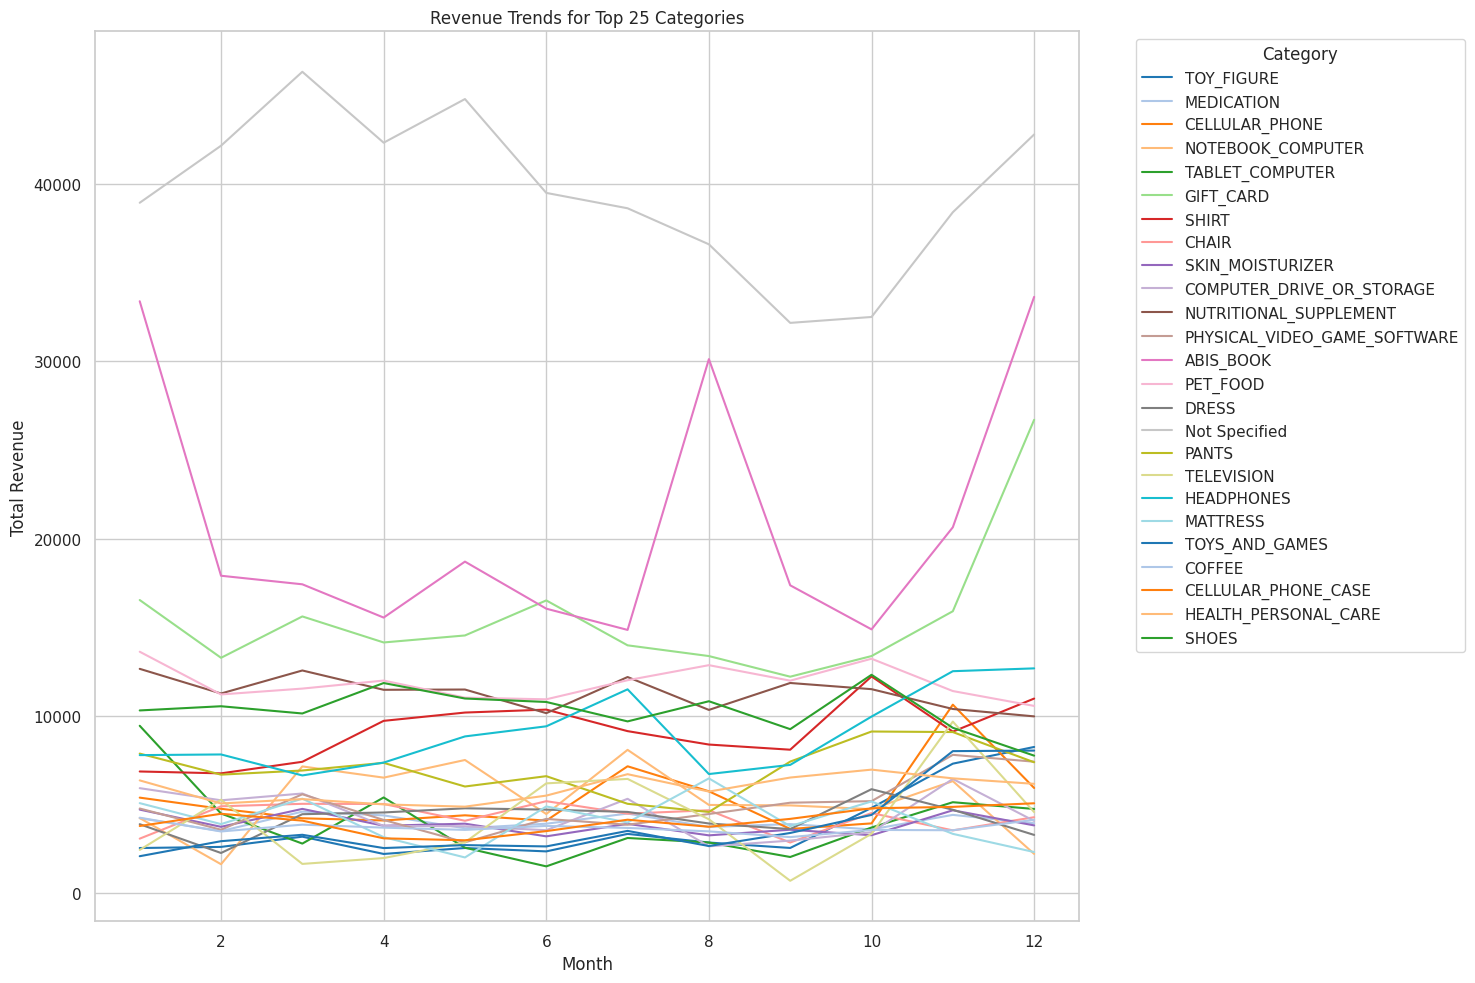

In [98]:
# Plot revenue trends for top 25 categories

plt.figure(figsize=(15, 10))

sns.lineplot(data=category_trends_pd, x='Month', y='Total Revenue', hue='Category', palette='tab20')

plt.title('Revenue Trends for Top 25 Categories')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Some Top-Category Product like ABIS Book, Cellular Phone, Toy Figure, Gift Cards and many mores has more demand for purchase.

### 4.2.7 Assess how bulk purchases affect revenue and supply chain operations <font color = red>[5 marks]</font> <br>

Analyse the impact of how bulk purchasing behavior affects revenue and the overall supply chain operations.

In [99]:
#Assess how bulk purchases affect revenue and supply chain operations

# Filter bulk purchases (Quantity > 5) and compute total revenue per category

bulk_pur_df = merged_data.filter(col('Quantity') > 5)

bulk_rev_by_category = bulk_pur_df.groupBy('Category') \
    .agg(sum('Purchase Price Per Unit').alias('Total Revenue')) \
    .orderBy(col('Total Revenue').desc())

# Select the top 25 categories by total revenue

bulk_categories_top_25 = bulk_rev_by_category.limit(25)


<ipython-input-100-b13f18f19a11>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bulk_categories_top_25_pd, x='Category', y='Total Revenue', palette='viridis')


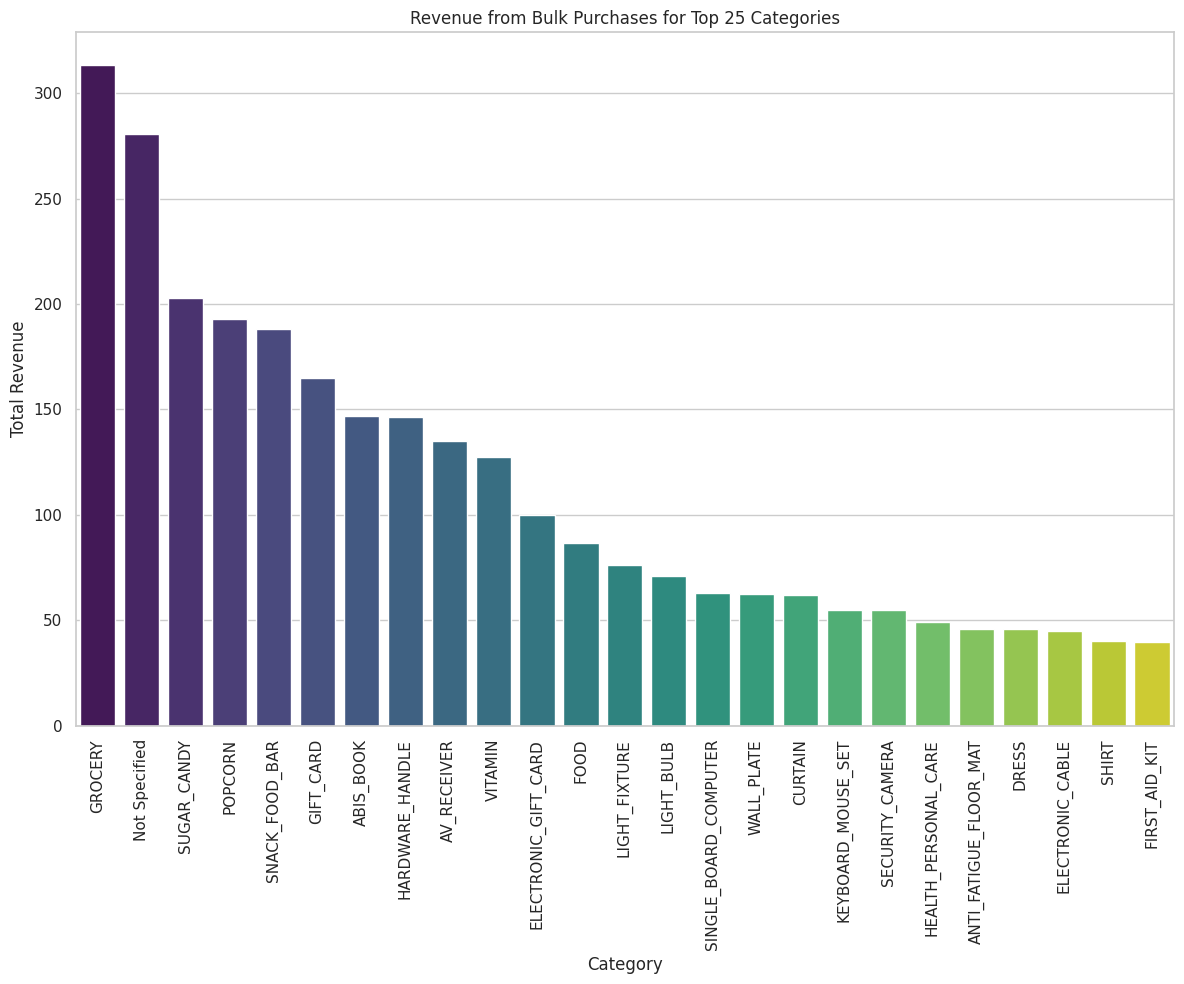

In [100]:
# Convert to Pandas for visualisation

bulk_categories_top_25_pd = bulk_categories_top_25.toPandas()

# Plot revenue from bulk purchases (Top 25 categories)

plt.figure(figsize=(12, 10))
sns.barplot(data=bulk_categories_top_25_pd, x='Category', y='Total Revenue', palette='viridis')

# Add labels and title
plt.title('Revenue from Bulk Purchases for Top 25 Categories')
plt.xlabel('Category')
plt.ylabel('Total Revenue')
plt.xticks(rotation=90)
plt.tight_layout()

# Show plot
plt.show()

Categories mostly "Grocery" following with Sugar Candy, Popcorn and Snack Food Bar are some top Bulk Purchases.

### 4.2.8 Compare lifecycle strategies <font color = red>[5 marks]</font> <br>

Compare new and established products to inform and compare lifecycle strategies to make informed decisions.

In [101]:
#Compare new and established products to inform lifecycle strategies

from pyspark.sql.functions import min, sum

# Compute "Launch Year" as the first recorded sale year for each product

launch_yr_df = merged_data.groupBy('ASIN/ISBN (Product Code)') \
    .agg(min(year('Order Date')).alias('Launch Year'))

# Join this back to the main dataset

merged_launch_yr = merged_data.join(launch_yr_df, 'ASIN/ISBN (Product Code)', 'inner')

# Now, we can compute revenue by launch year

rev_launch_year = merged_launch_yr.groupBy('Launch Year') \
    .agg(sum('Purchase Price Per Unit').alias('Total Revenue')) \
    .orderBy('Launch Year')

# show data

rev_launch_year.show()

+-----------+------------------+
|Launch Year|     Total Revenue|
+-----------+------------------+
|       2018|  1722664.94999963|
|       2019|1441716.0099997178|
|       2020|1841822.0899995517|
|       2021| 1945504.859999567|
|       2022|1549732.2499996945|
|       2023|124145.64999999855|
+-----------+------------------+



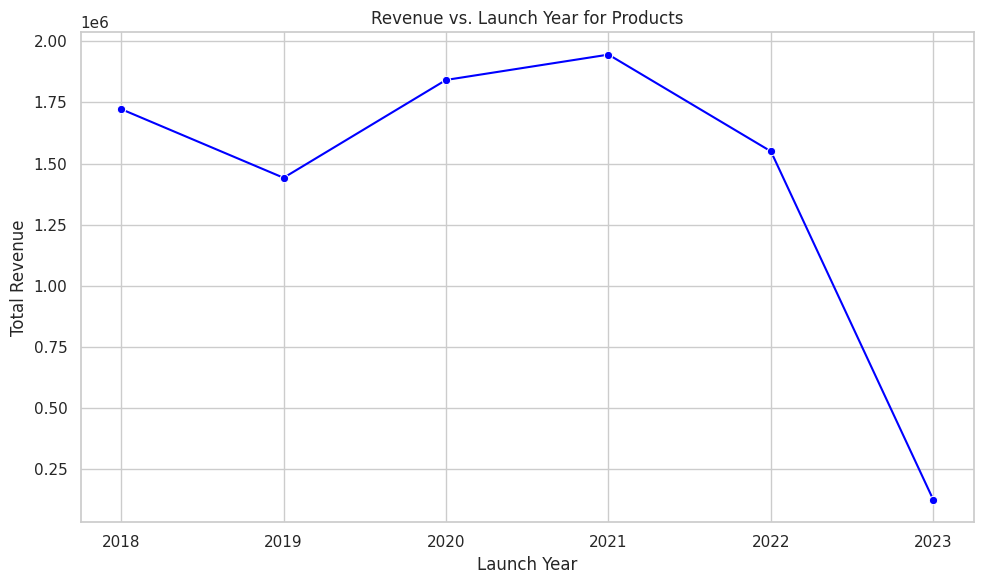

In [102]:
# Convert to Pandas

rev_launch_yr_pd = rev_launch_year.toPandas()

# Plot revenue vs. launch year

plt.figure(figsize=(10, 6))
sns.lineplot(data=rev_launch_yr_pd, x='Launch Year', y='Total Revenue', marker='o', color='blue')

# Adding labels and title
plt.title('Revenue vs. Launch Year for Products')
plt.xlabel('Launch Year')
plt.ylabel('Total Revenue')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

The products Launched in Year 2021 showed high revenue eventually declined after coming to Year 2023.

#5 Conclusion <font color = red>[10 marks]</font> <br>

Write your conclusion.

The comprehensive analysis conducted using the RFM model, clustering, and various other analytical approaches has provided valuable insights into customer behavior, product performance, and operational strategies. The findings from the study can be summarized as follows:

1. **Seasonal Trends** : The overall Purchase trends were mostly high in Year **'2020'** and **'2021'** with Month of **"December"**.

2. **Gender and Age** : We saw that **Females** with age group of **55-64 years** showed great purchase frequency as compared to other Gender categories.

3. **Education and Income Level** : Company must prefer the customers having **"prefer not to say"** education level with income Level of **$50,000-74,999 ** makes highest number of Purchases.

4. **State and Race** : The people living in **California** and belongs to **White or Caucasian** showed highly interest in purchasing products.

5. **Weekdays vs. Weekends** : **Weekday** analysis revealed higher sales volumes on **"Monday"**, suggesting optimal days for promotional campaigns moreover on weekdays.

6. The **spending KPIs** for E-commerce Company was found to be around **8222.85**.

7. **Repeat Purchase** : A significant portion of customers exhibited **repeat purchase** behavior to enhance retention initiatives.

8. **Top Engaged Customer** : Some top customers had high Purchase frequency and must be provided with regular discount and offers for being loyal customer to company.

9. **Top-Selling Products** : The Product code with **B00IX1I3G6** followed by some top 10 products can help in revenue growth by increasing their sales.

10. **Potential Fraud** : Detected some irregular transaction patterns to flag potential fraud. Based on these findings can mitigate financial risks.

11. **Top-Category Product** : Product category like **ABIS_Book**, **Cellular Phone**, **Toy Figure**, **Gift Cards** and many more has great demand for purchase.

12. **Top-Bulk Purchase** : Categories mostly **"Grocery"** following with **Sugar Candy**, **Popcorn** and **Snack Food Bar** are some top Bulk Purchases. Negotiating better supplier deals and managing inventory levels can further improve margins.

13. **Lifecycle Strategies** : Products Launched in Year **2021** showed high revenue eventually declined after coming to Year **2023**. Marketing strategies can be adjusted to support new product launches or phase out declining products.


#### ***This analysis provides actionable insights for improving business performance, increasing customer satisfaction, and driving revenue growth.***